In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from sklearn.model_selection import train_test_split
#import xgboost_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ridge_regression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

### 1. Data cleaning

In [5]:
pv=pd.read_csv('mweb_pv_us_bymetro2018.csv')
wx=pd.read_csv('mweb_wx_us_bymetro2018.csv')
pv.head(10)
wx.head(10)#the dates are in different format in two datasets

pv['date']=pd.to_datetime(pv['date'],format='%Y%m%d')
pv.head()
wx['date']=pd.to_datetime(wx['date'],format='%Y-%m-%d')
wx.head()

pv.describe()
pv.shape#(76969, 3)
wx.shape #(76965, 5)

# check the data types of each column
pv.dtypes
wx.dtypes

# merge the datasets
wx_pv=pd.merge(wx,pv,on=['date','metro'])

wx_pv.shape#(76604, 6)
wx_pv.isnull().sum() #no missing values
wx_pv.head()

,date,metro,cur_temp_avg,cur_humidity_avg,cur_wind_avg,pageviews
0,2018-07-26,Cedar Rapids-Waterloo-Iowa City & Dubuque IA,70.975,72.655,9.070,20307
1,2018-11-18,Denver CO,34.232,68.920,4.834,157006
2,2018-07-11,Idaho Falls-Pocatello ID,77.425,38.650,9.050,2962
3,2018-06-06,Detroit MI,62.920,62.483,5.646,471089
4,2018-08-08,Portland-Auburn ME,78.583,80.242,4.385,62576


### 2. EDA

In [6]:
wx_pv_stats = wx_pv.describe()
wx_pv_stats

,cur_temp_avg,cur_humidity_avg,cur_wind_avg,pageviews
count,76604.000000,76604.000000,76604.000000,7.660400e+04
mean,58.741732,68.818781,7.717365,7.190669e+04
std,19.088606,13.449156,2.891489,1.705825e+05
min,7.040000,14.032000,1.354000,1.000000e+00
25%,43.513750,61.039000,5.645000,6.964000e+03
50%,60.649500,70.949000,7.243000,1.779650e+04
75%,75.349250,78.547000,9.258000,5.667175e+04
max,105.967000,96.740000,28.964000,6.929540e+06


In [7]:
wx_pv.describe()

,cur_temp_avg,cur_humidity_avg,cur_wind_avg,pageviews
count,76604.000000,76604.000000,76604.000000,7.660400e+04
mean,58.741732,68.818781,7.717365,7.190669e+04
std,19.088606,13.449156,2.891489,1.705825e+05
min,7.040000,14.032000,1.354000,1.000000e+00
25%,43.513750,61.039000,5.645000,6.964000e+03
50%,60.649500,70.949000,7.243000,1.779650e+04
75%,75.349250,78.547000,9.258000,5.667175e+04
max,105.967000,96.740000,28.964000,6.929540e+06


In [8]:
wx_pv_stats.to_csv('wx_pv_stats.csv')
wx_pv.to_csv('wx_pv.csv')

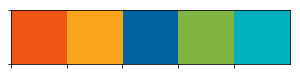

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
flatui = ["#f05514", "#faa519","#0064a0","#82b441","#00afbe"]
k=sns.set_palette(flatui)
sns.palplot(sns.color_palette())

### 2.1 Plot out general distribution of the variables for all metros

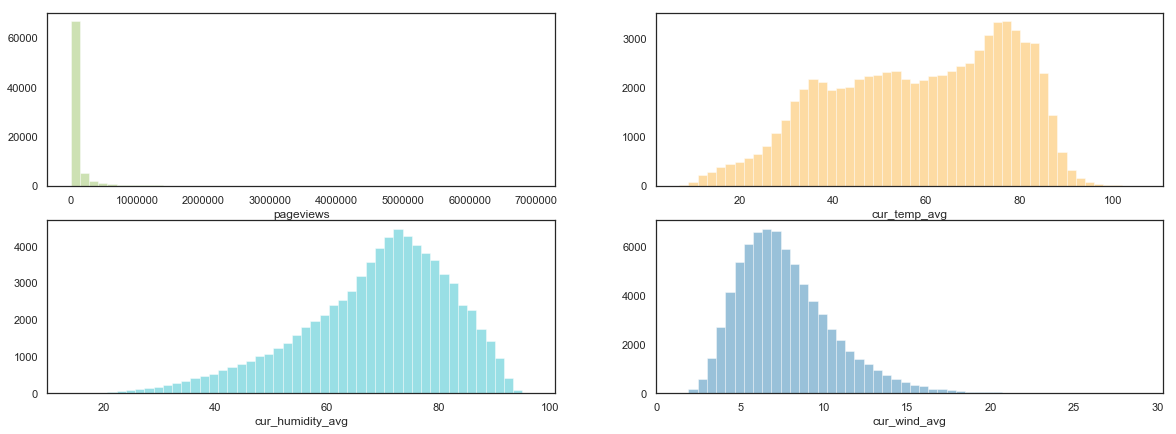

In [10]:
sb.set(style='white',palette=k,color_codes=False)
f,axes=plt.subplots(2,2,figsize=(20,7),sharex=False)
sb.distplot(wx_pv['pageviews'],kde=False,color='#82b441',ax=axes[0,0])
sb.distplot(wx_pv['cur_temp_avg'],kde=False, color='#faa519',ax=axes[0,1])
sb.distplot(wx_pv['cur_humidity_avg'],kde=False, color='#00afbe',ax=axes[1,0])
sb.distplot(wx_pv['cur_wind_avg'],kde=False, color='#0064a0',ax=axes[1,1])
plt.savefig('overall_dist.jpg')

In [11]:
len(wx_pv['metro'].unique())#210 metros
wx_pv['metro'].value_counts()# majority has 365 data points, this is a very balanced data set

Bluefield-Beckley-Oak Hill WV               365
Los Angeles CA                              365
Tallahassee FL-Thomasville GA               365
Des Moines-Ames IA                          365
Toledo OH                                   365
Bakersfield CA                              365
La Crosse-Eau Claire WI                     365
Chicago IL                                  365
Harrisburg-Lancaster-Lebanon-York PA        365
Odessa-Midland TX                           365
Austin TX                                   365
Jackson MS                                  365
Syracuse NY                                 365
Buffalo NY                                  365
Wilmington NC                               365
Butte-Bozeman MT                            365
Marquette MI                                365
Sherman-Ada, OK                             365
Huntsville-Decatur (Florence) AL            365
Casper-Riverton WY                          365
Terre Haute IN                          

In [12]:
wx_pv['metro'].unique()
wx_pv.to_csv('wx_pv2018.csv')

#### Plot out pageviews by top 12 metros: NYC, Chicago, Los Angeles, Dallas, Philly, Houston, Washington DC, Miami, Atlanta, Boston, San Francisco, Detroit

1. DC, Boston, Philly, Detroit, Atlanta, Houston, Dallas, LA has most of their PV between 500k -1M
2. NYC has many data points around 2M Pvs and Chicago often reach to PV of 2.5M
3. Miami and San Francisco has a relative smaller scale of PV range with highest 400k and 600k respectively

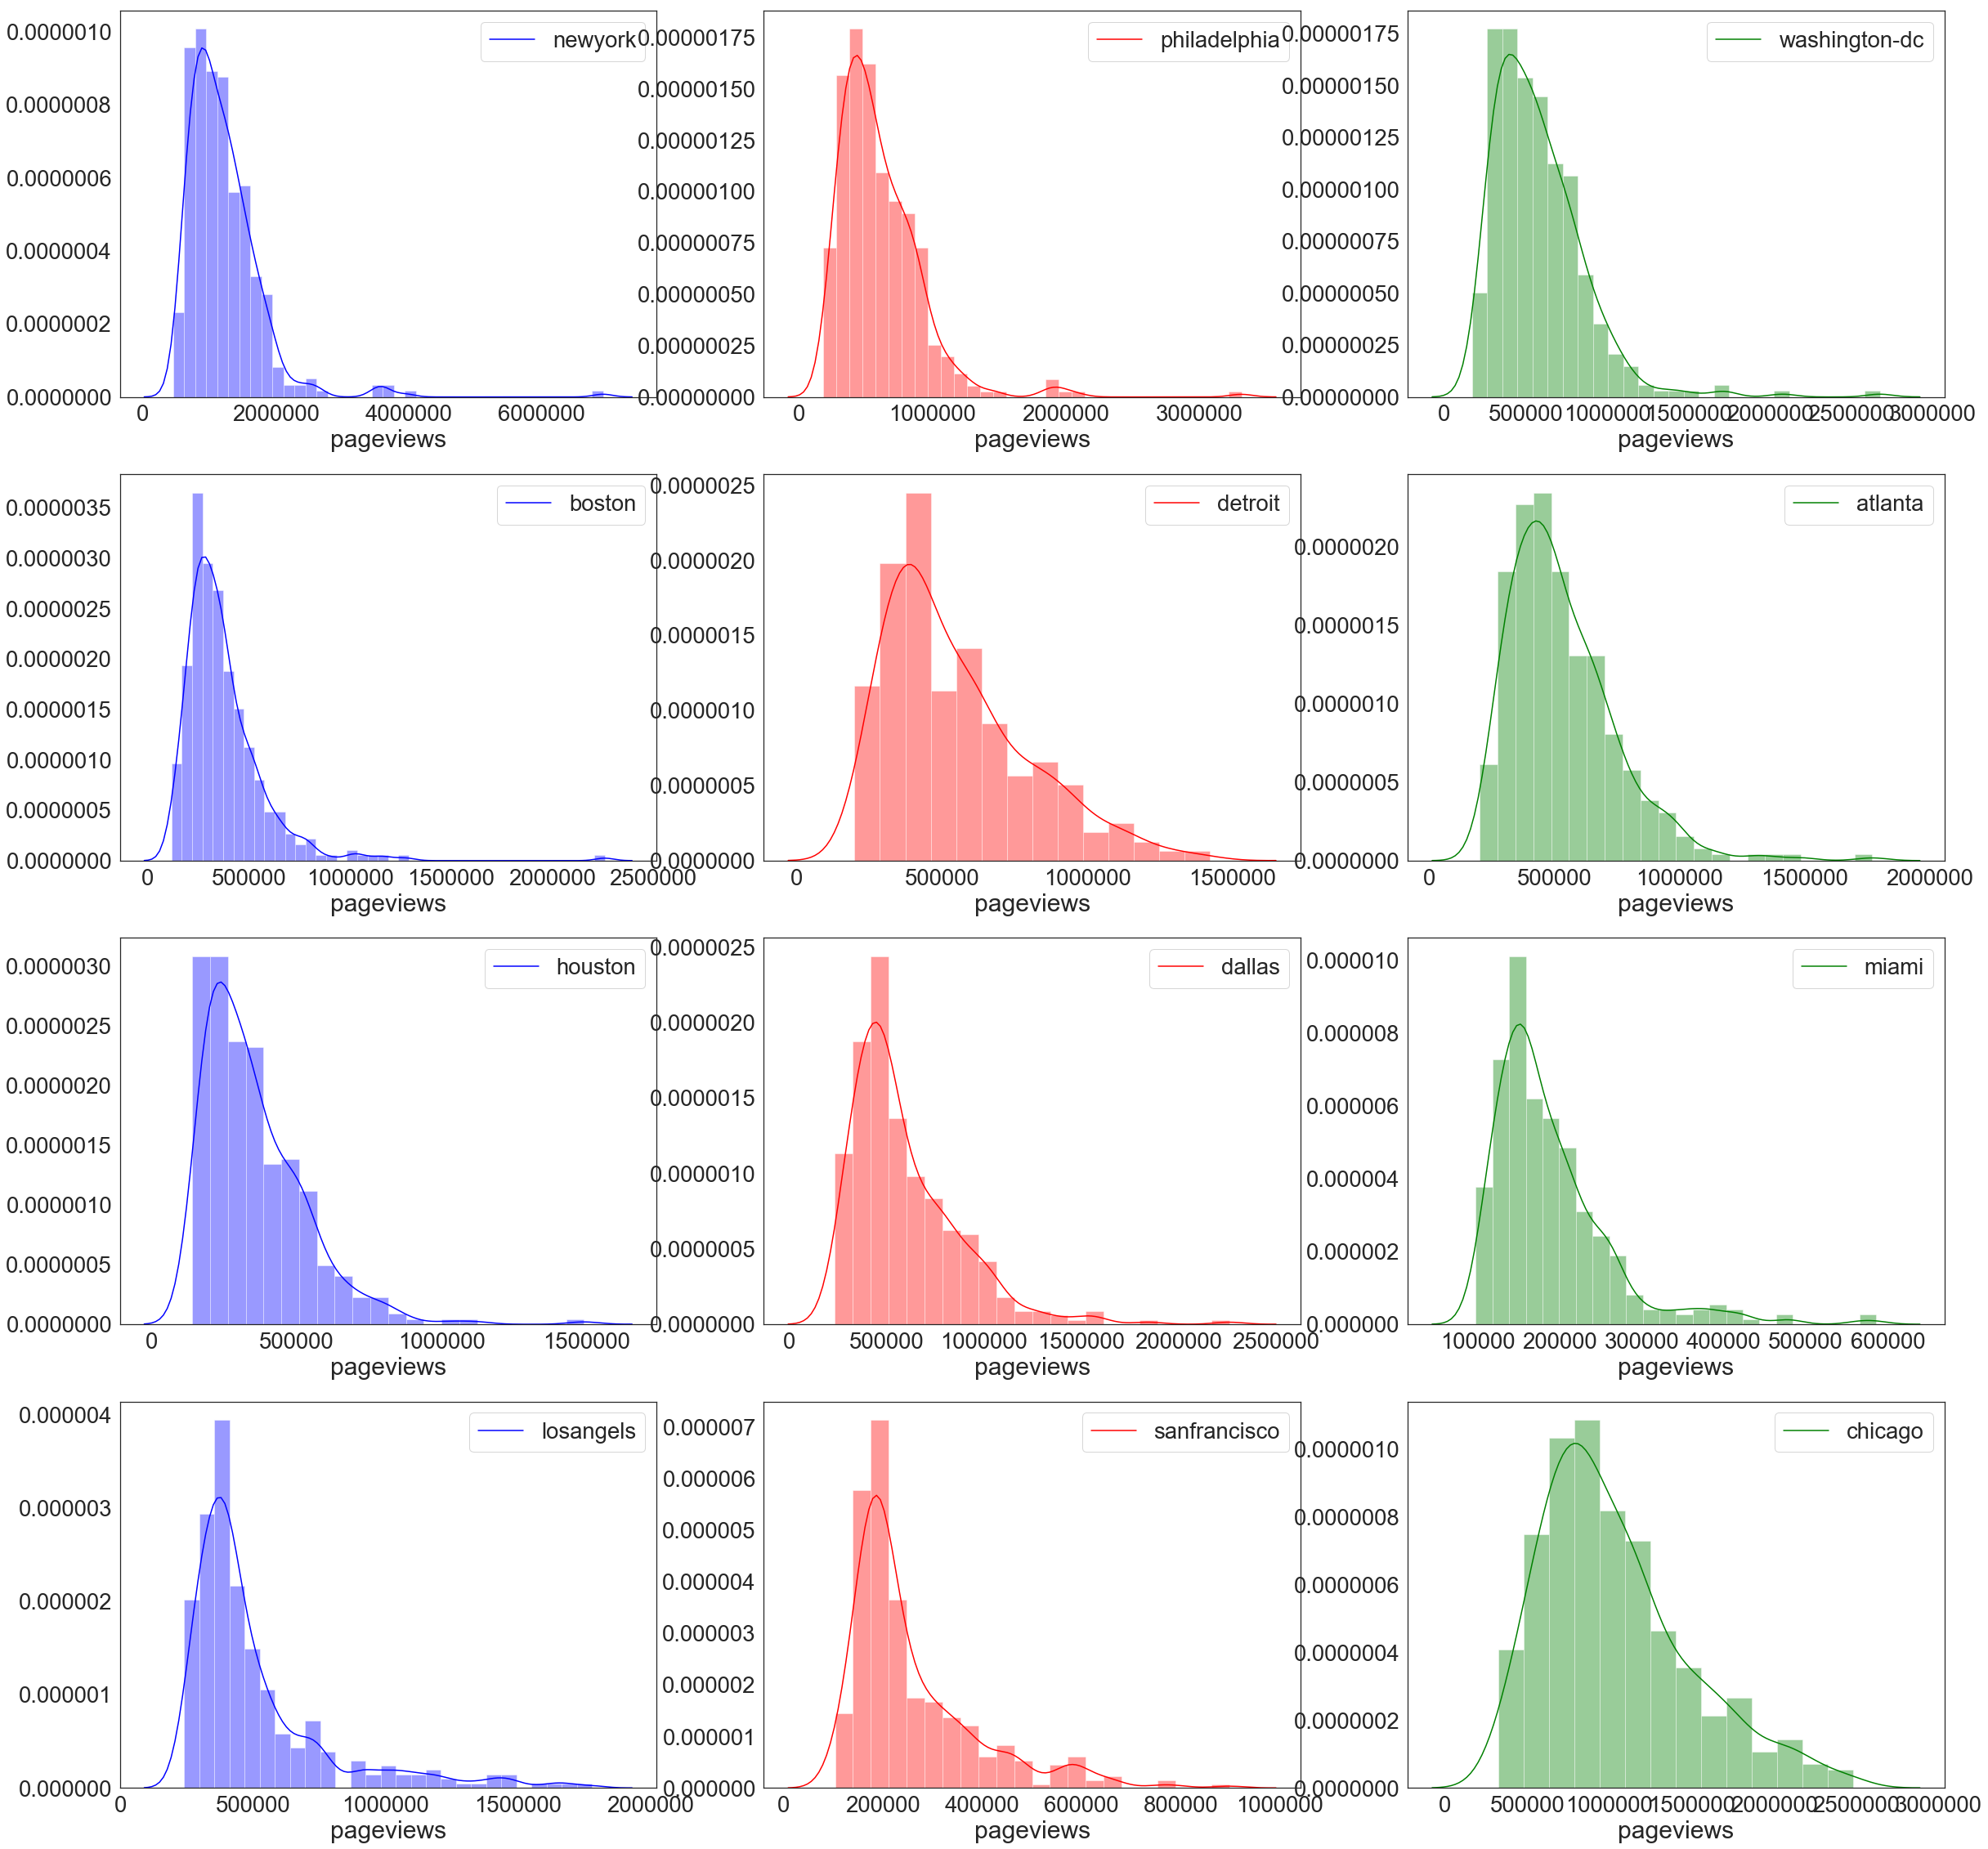

In [13]:
# plot out largest metro in use according to: https://www.currentresults.com/Weather-Extremes/US/largest-cities-list.php
chi=wx_pv[wx_pv['metro']=='Chicago IL']
nyc=wx_pv[wx_pv['metro']=='New York NY']
la=wx_pv[wx_pv['metro']=='Los Angeles CA']
dal=wx_pv[wx_pv['metro']=='Dallas-Ft. Worth TX']
phil=wx_pv[wx_pv['metro']=='Philadelphia PA']
hou=wx_pv[wx_pv['metro']=='Houston TX']
dc=wx_pv[wx_pv['metro']=='Washington DC (Hagerstown MD)']
mia=wx_pv[wx_pv['metro']=='Miami-Ft. Lauderdale FL']
atl=wx_pv[wx_pv['metro']=='Atlanta GA']
bos=wx_pv[wx_pv['metro']=='Boston MA-Manchester NH']
sf=wx_pv[wx_pv['metro']=='San Francisco-Oakland-San Jose CA']
det=wx_pv[wx_pv['metro']=='Detroit MI']


sb.set(style='white',palette=k,color_codes=True,font_scale=2.5)
f,axes=plt.subplots(4,3,figsize=(40,40),sharex=False)


sb.distplot(nyc['pageviews'],color='b',ax=axes[0,0],kde_kws={'label':"newyork"})
sb.distplot(phil['pageviews'],color='r',ax=axes[0,1],kde_kws={'label':"philadelphia"})
sb.distplot(dc['pageviews'],color='g',ax=axes[0,2],kde_kws={'label':"washington-dc"})

sb.distplot(bos['pageviews'], color='b',ax=axes[1,0],kde_kws={'label':"boston"})
sb.distplot(det['pageviews'], color='r',ax=axes[1,1],kde_kws={'label':"detroit"})
sb.distplot(atl['pageviews'], color='g',ax=axes[1,2],kde_kws={'label':"atlanta"})

sb.distplot(hou['pageviews'], color='b',ax=axes[2,0],kde_kws={'label':"houston"})
sb.distplot(dal['pageviews'], color='r',ax=axes[2,1],kde_kws={'label':"dallas"})
sb.distplot(mia['pageviews'], color='g',ax=axes[2,2],kde_kws={'label':"miami"})

sb.distplot(la['pageviews'], color='b',ax=axes[3,0],kde_kws={'label':"losangels"})
sb.distplot(sf['pageviews'], color='r',ax=axes[3,1],kde_kws={'label':"sanfrancisco"})
sb.distplot(chi['pageviews'], color='g',ax=axes[3,2],kde_kws={'label':"chicago"})
plt.savefig('pv_dist.jpg')

#### Plot out avg current temperature by top 12 metros
1. NYC, Philly, Detroit, Boston and Chicago have very similar temperature pattern distribution over the year with more days centering around 40F and 80F
2. Atlanta, Houston, Dallas have the same pattern for avg. temperature with more days centering around 60F and 80F
    * Miami has the similar pattern but with more days centering around 70F and 90F
3. Los Angeles and San Francisco have similar avg. temperature pattern with differing peak temperatures. LA has more days centering around 60F and 80F but SF around 50F and 65F

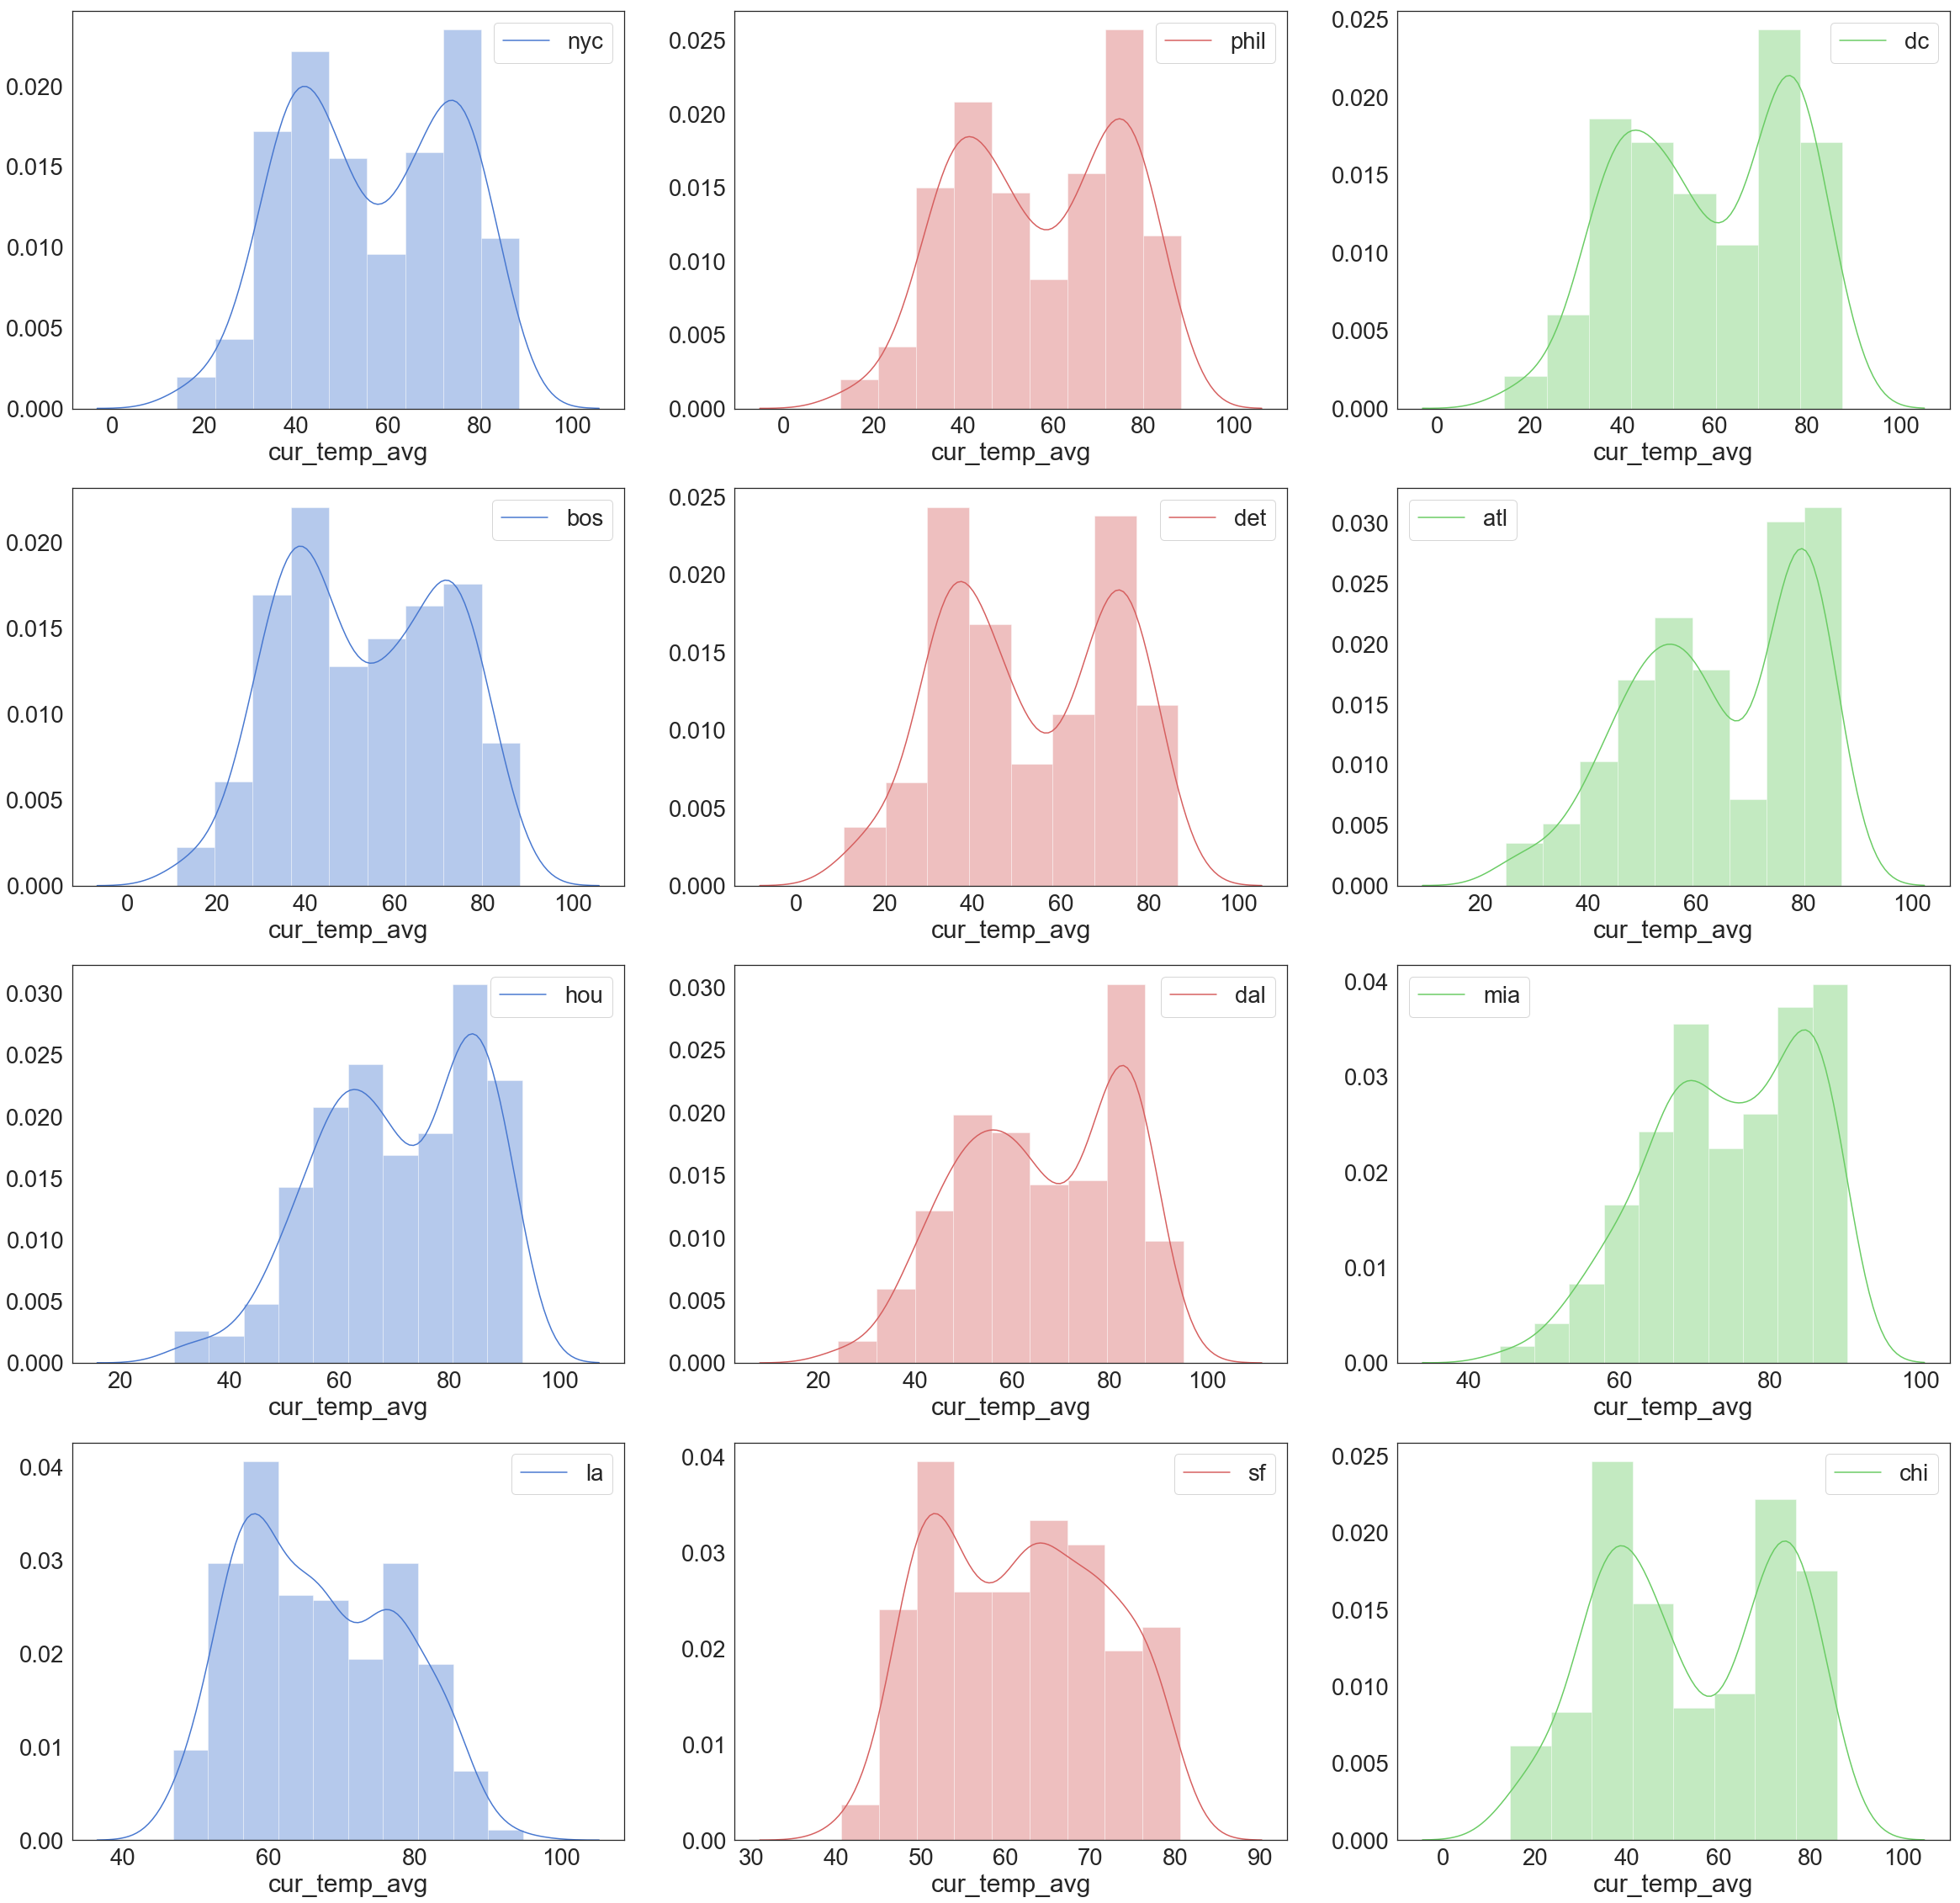

In [14]:
sb.set(style='white',palette='muted',color_codes=True,font_scale=2.5)
f,axes=plt.subplots(4,3,figsize=(40,40),sharex=False)


sb.distplot(nyc['cur_temp_avg'],color='b',ax=axes[0,0],kde_kws={'label':"nyc"})
sb.distplot(phil['cur_temp_avg'],color='r',ax=axes[0,1],kde_kws={'label':"phil"})
sb.distplot(dc['cur_temp_avg'],color='g',ax=axes[0,2],kde_kws={'label':"dc"})

sb.distplot(bos['cur_temp_avg'], color='b',ax=axes[1,0],kde_kws={'label':"bos"})
sb.distplot(det['cur_temp_avg'], color='r',ax=axes[1,1],kde_kws={'label':"det"})
sb.distplot(atl['cur_temp_avg'], color='g',ax=axes[1,2],kde_kws={'label':"atl"})

sb.distplot(hou['cur_temp_avg'], color='b',ax=axes[2,0],kde_kws={'label':"hou"})
sb.distplot(dal['cur_temp_avg'], color='r',ax=axes[2,1],kde_kws={'label':"dal"})
sb.distplot(mia['cur_temp_avg'], color='g',ax=axes[2,2],kde_kws={'label':"mia"})

sb.distplot(la['cur_temp_avg'], color='b',ax=axes[3,0],kde_kws={'label':"la"})
sb.distplot(sf['cur_temp_avg'], color='r',ax=axes[3,1],kde_kws={'label':"sf"})
sb.distplot(chi['cur_temp_avg'], color='g',ax=axes[3,2],kde_kws={'label':"chi"})
plt.savefig('temp_dist.jpg')

#### Plot out avg current humidity by top 12 metros
1. Philly, DC, Detroit, Atlanta and Chicago have the similar avg. humidity pattern with peak humidity level of 80% and more days between humidity level of 40 and 80%
    * NYC has peak humidity on 60-65% and 80%
2. Boston, Houston and Dallas have the similar avg. humidity pattern with peak humidity level of 60-65%  and more days between humidity level of 70 and 90%
    * Miami has a bell-shape humidity pattern with peak at 75% and everything else balanced out
3. LA and SF has the similar humidity pattern with peak surrounding 60 % and mored days between 60-80 %

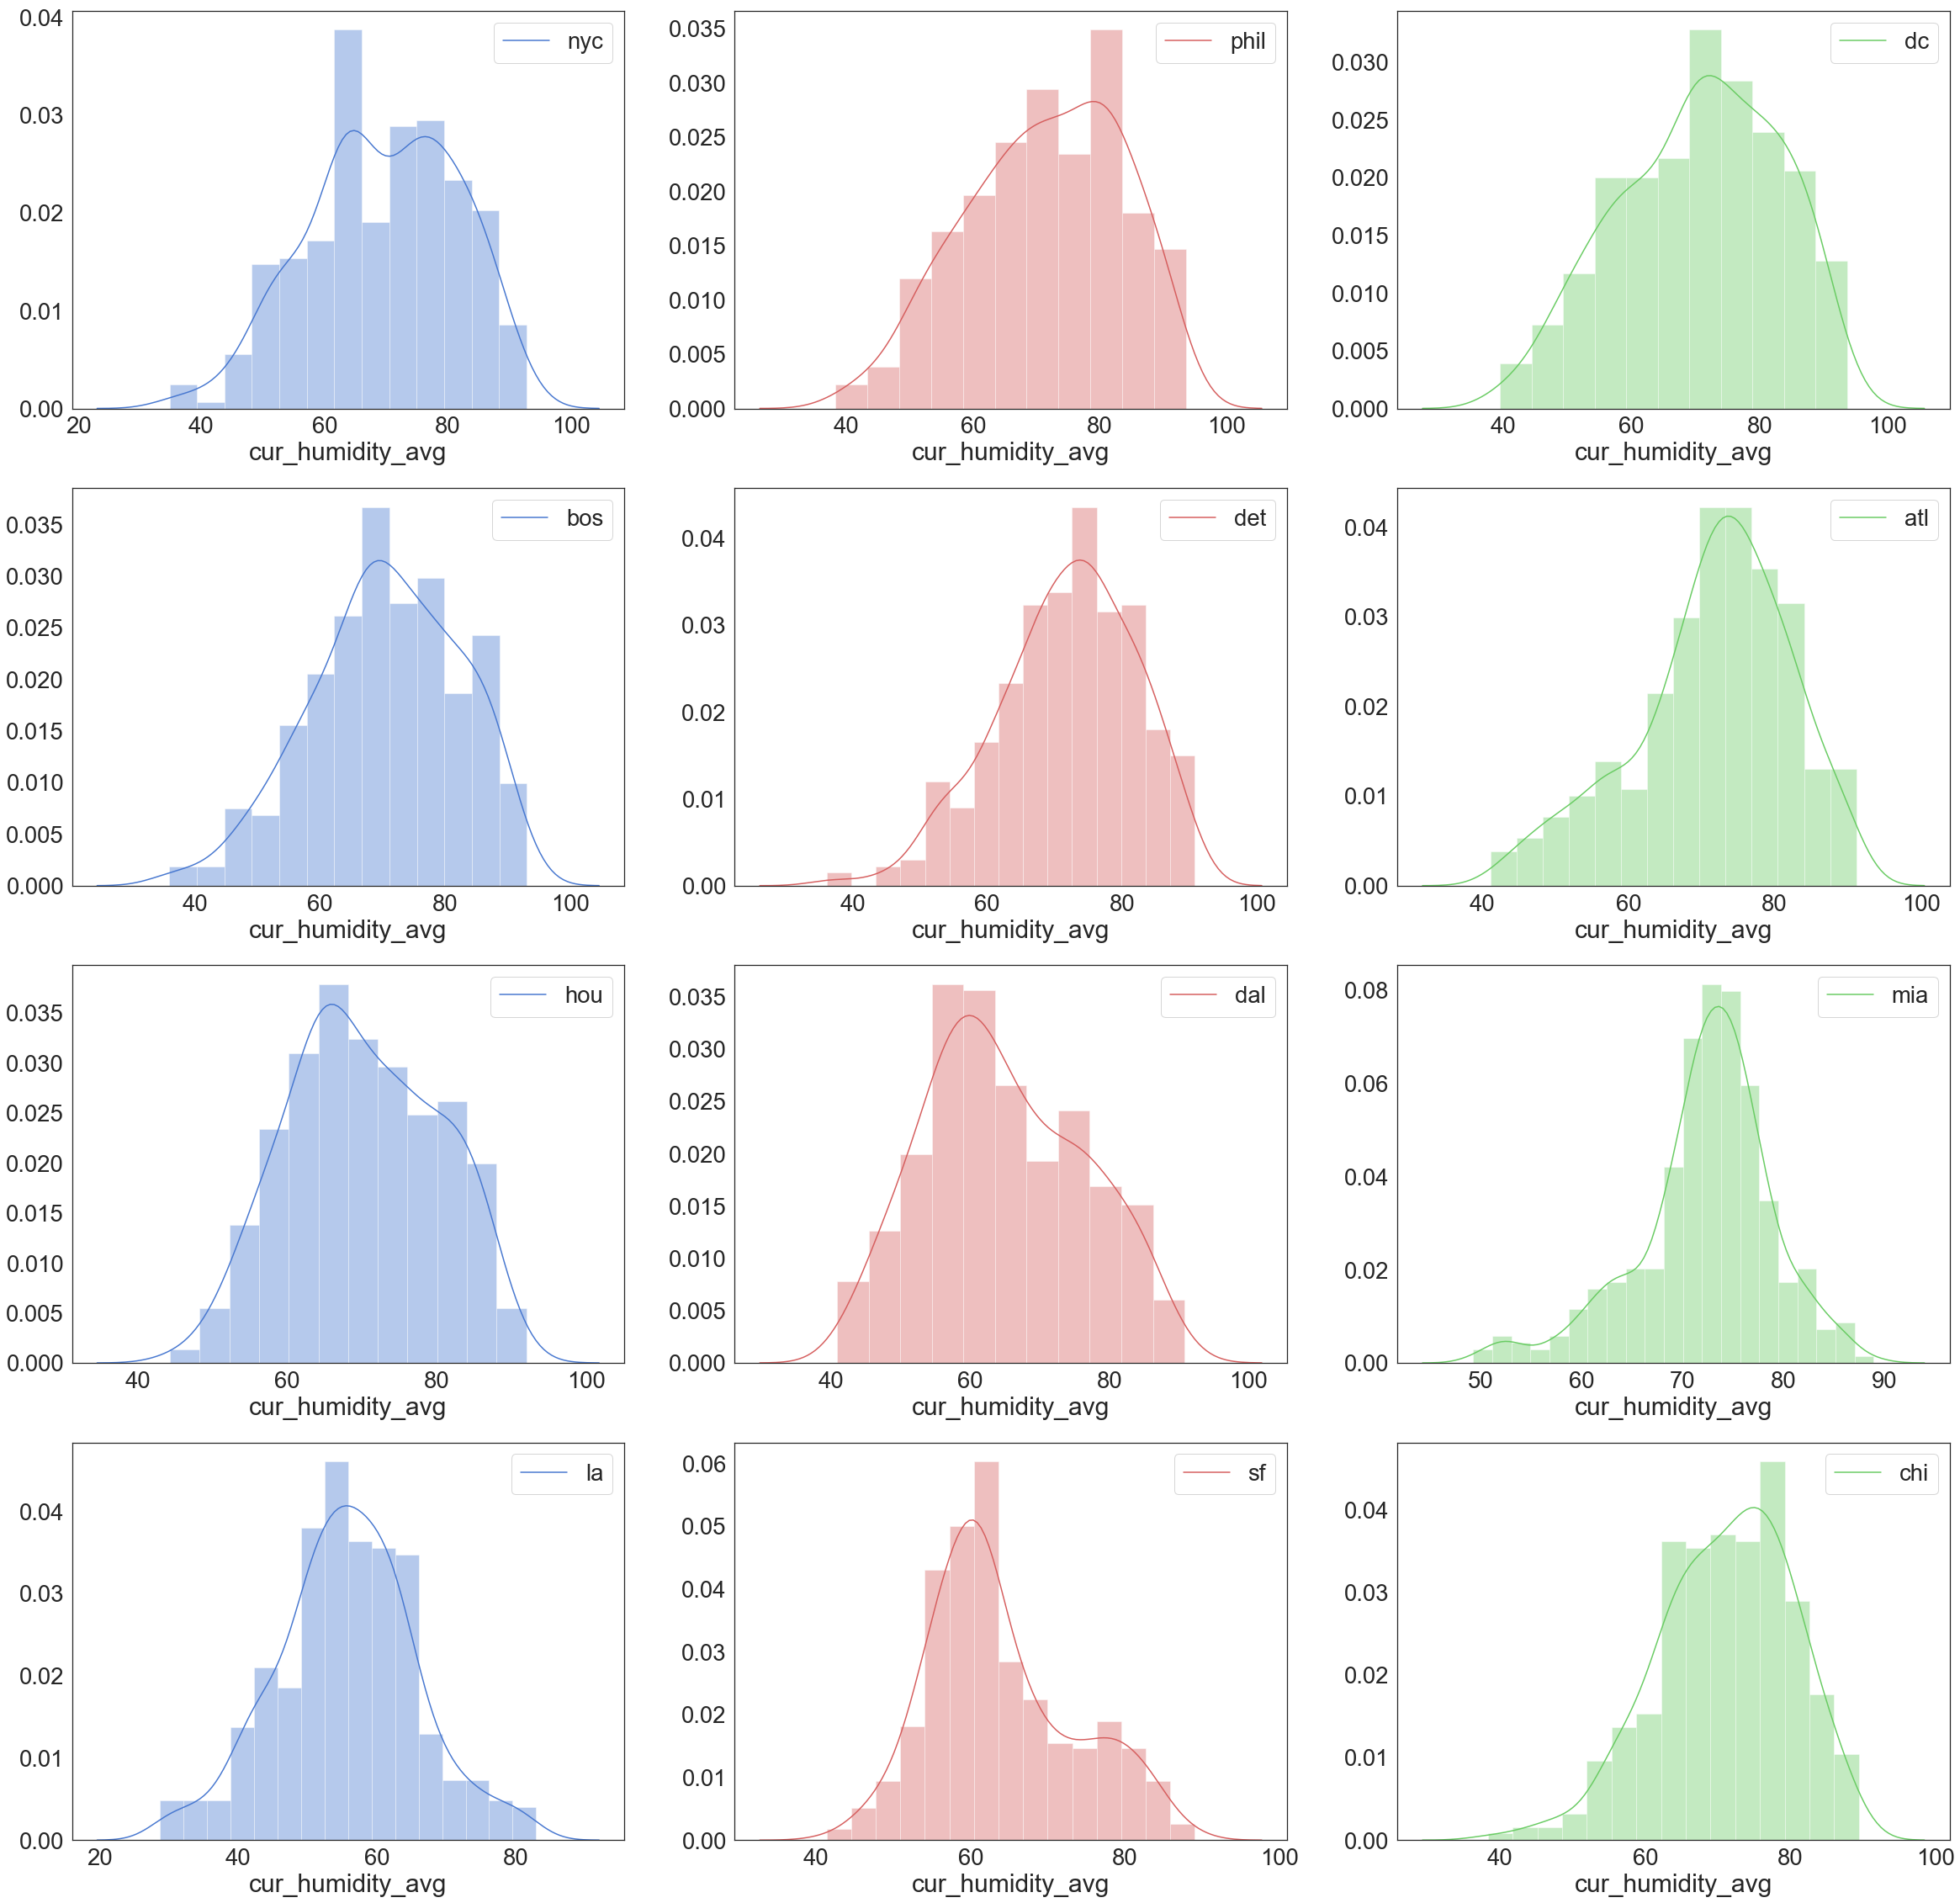

In [15]:
sb.set(style='white',palette='muted',color_codes=True,font_scale=2.5)
f,axes=plt.subplots(4,3,figsize=(40,40),sharex=False)

sb.distplot(nyc['cur_humidity_avg'],color='b',ax=axes[0,0],kde_kws={'label':"nyc"})
sb.distplot(phil['cur_humidity_avg'],color='r',ax=axes[0,1],kde_kws={'label':"phil"})
sb.distplot(dc['cur_humidity_avg'],color='g',ax=axes[0,2],kde_kws={'label':"dc"})

sb.distplot(bos['cur_humidity_avg'], color='b',ax=axes[1,0],kde_kws={'label':"bos"})
sb.distplot(det['cur_humidity_avg'], color='r',ax=axes[1,1],kde_kws={'label':"det"})
sb.distplot(atl['cur_humidity_avg'], color='g',ax=axes[1,2],kde_kws={'label':"atl"})

sb.distplot(hou['cur_humidity_avg'], color='b',ax=axes[2,0],kde_kws={'label':"hou"})
sb.distplot(dal['cur_humidity_avg'], color='r',ax=axes[2,1],kde_kws={'label':"dal"})
sb.distplot(mia['cur_humidity_avg'], color='g',ax=axes[2,2],kde_kws={'label':"mia"})

sb.distplot(la['cur_humidity_avg'], color='b',ax=axes[3,0],kde_kws={'label':"la"})
sb.distplot(sf['cur_humidity_avg'], color='r',ax=axes[3,1],kde_kws={'label':"sf"})
sb.distplot(chi['cur_humidity_avg'], color='g',ax=axes[3,2],kde_kws={'label':"chi"})
plt.savefig('humd_dist.jpg')

#### Plot out avg current wind by top 12 metros
1. NYC, Philly, DC,Boston, Detroit and Chicago have the similar avg. wind distribution over the year with most frequent happening speed of 7.5 mph and other frequent wind speeds are between 7.5 to 20 mph. 
    * Atlanta has most frequent happening speed of around 5 and other frequent wind speeds are between 5 to 12.5 mph
2. Houston and Dallas have the similar pattern with similar peak around 7.5 mph
3. Miami, LA and SF have the similar pattern but Miami has a peak around 10 mph with LA and SF around 7.5 mph and more days between 4 to 7.5 mph

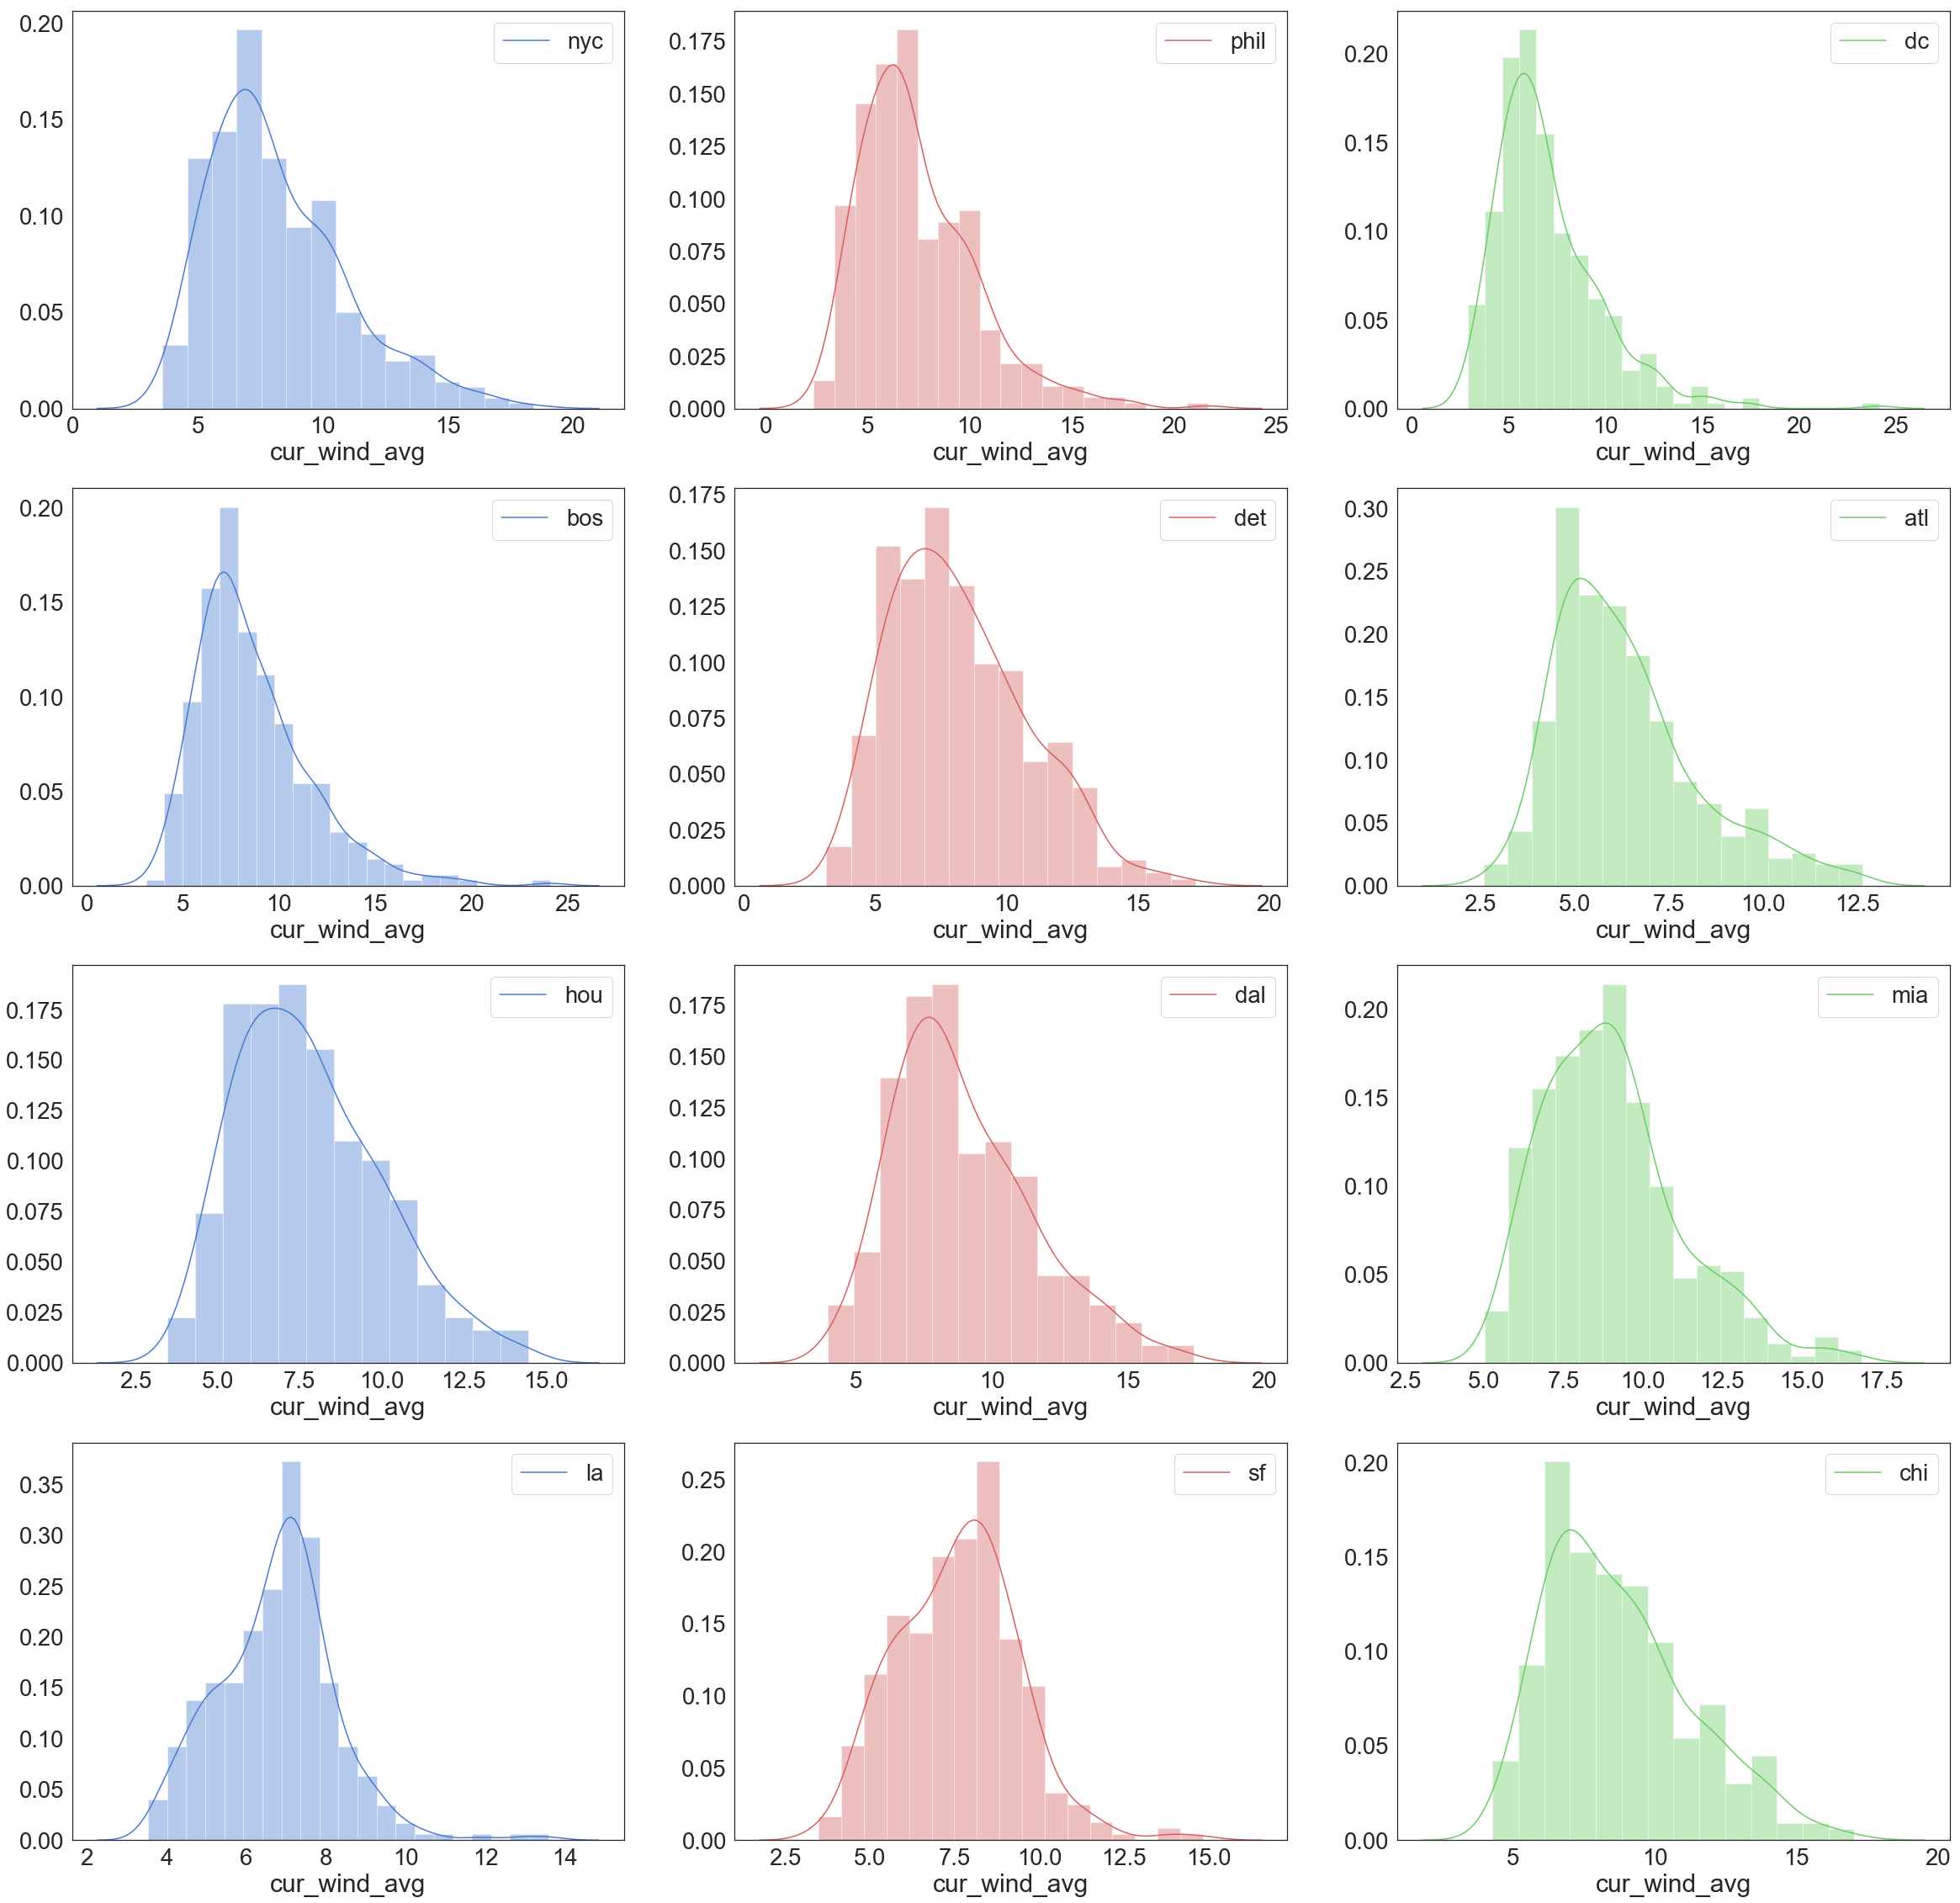

In [16]:
sb.set(style='white',palette='muted',color_codes=True,font_scale=2.5)
f,axes=plt.subplots(4,3,figsize=(40,40),sharex=False)

sb.distplot(nyc['cur_wind_avg'],color='b',ax=axes[0,0],kde_kws={'label':"nyc"})
sb.distplot(phil['cur_wind_avg'],color='r',ax=axes[0,1],kde_kws={'label':"phil"})
sb.distplot(dc['cur_wind_avg'],color='g',ax=axes[0,2],kde_kws={'label':"dc"})

sb.distplot(bos['cur_wind_avg'], color='b',ax=axes[1,0],kde_kws={'label':"bos"})
sb.distplot(det['cur_wind_avg'], color='r',ax=axes[1,1],kde_kws={'label':"det"})
sb.distplot(atl['cur_wind_avg'], color='g',ax=axes[1,2],kde_kws={'label':"atl"})

sb.distplot(hou['cur_wind_avg'], color='b',ax=axes[2,0],kde_kws={'label':"hou"})
sb.distplot(dal['cur_wind_avg'], color='r',ax=axes[2,1],kde_kws={'label':"dal"})
sb.distplot(mia['cur_wind_avg'], color='g',ax=axes[2,2],kde_kws={'label':"mia"})

sb.distplot(la['cur_wind_avg'], color='b',ax=axes[3,0],kde_kws={'label':"la"})
sb.distplot(sf['cur_wind_avg'], color='r',ax=axes[3,1],kde_kws={'label':"sf"})
sb.distplot(chi['cur_wind_avg'], color='g',ax=axes[3,2],kde_kws={'label':"chi"})
plt.savefig('wind_dist.jpg')

### 2.2 Plot out correlations between IV and DV for all metros via scatter_matrix(), pairplot() or heatmap()

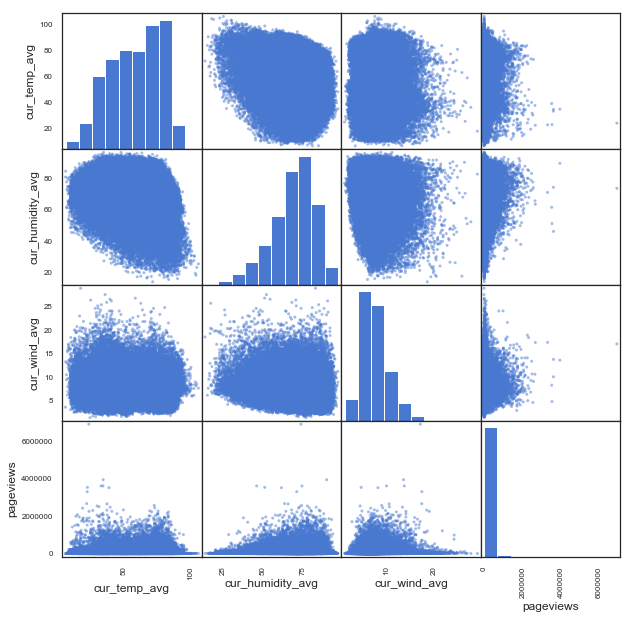

<Figure size 432x288 with 0 Axes>

In [17]:
# plt.matshow(wx_pv.corr())
# plt.xticks(range(len(wx_pv.columns)),wx_pv.columns)
# plt.yticks(range(len(wx_pv.columns)),wx_pv.columns)
# plt.colorbar()
# plt.show()
sb.set(style='white',palette='muted',color_codes=True)
pd.scatter_matrix(wx_pv,figsize=(10,10))
plt.show()
# seaborn's pariplot is also a correlogram which looks very much the same
# sb.pairplot(wx_pv)
# plt.show()
plt.savefig('scatter_matrix.jpg')

In [18]:
wx_pv_corr = wx_pv.corr()
wx_pv_corr.to_csv('wx_pv_corr.csv')
wx_pv.corr()

,cur_temp_avg,cur_humidity_avg,cur_wind_avg,pageviews
cur_temp_avg,1.000000,-0.117649,-0.188118,0.011606
cur_humidity_avg,-0.117649,1.000000,-0.146660,0.049950
cur_wind_avg,-0.188118,-0.146660,1.000000,0.050649
pageviews,0.011606,0.049950,0.050649,1.000000


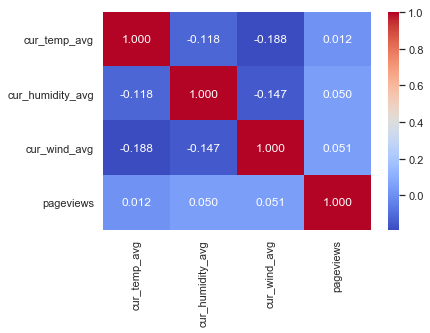

In [19]:
sb.set(style='white',palette='muted',color_codes=True)
sb.heatmap(wx_pv.corr(),annot=True,fmt='.3f',cmap='coolwarm')
plt.savefig('heatmap.jpg')#you can use 'Blues,coolwarm, Greens,BuPu, YlGnBu' to control the color

#### Plot out correlations between variables for top 12 metros
1. The correlation between avg. wind and pv is higher for Detroit and Chicago than for NYC, Philly, DC, Boston, Atlanta 
2. The correlation between avg. temperature and pv is higher for Detroit and Chicago
3. The correlation between avg. humidity and pv is higher for LA and SF

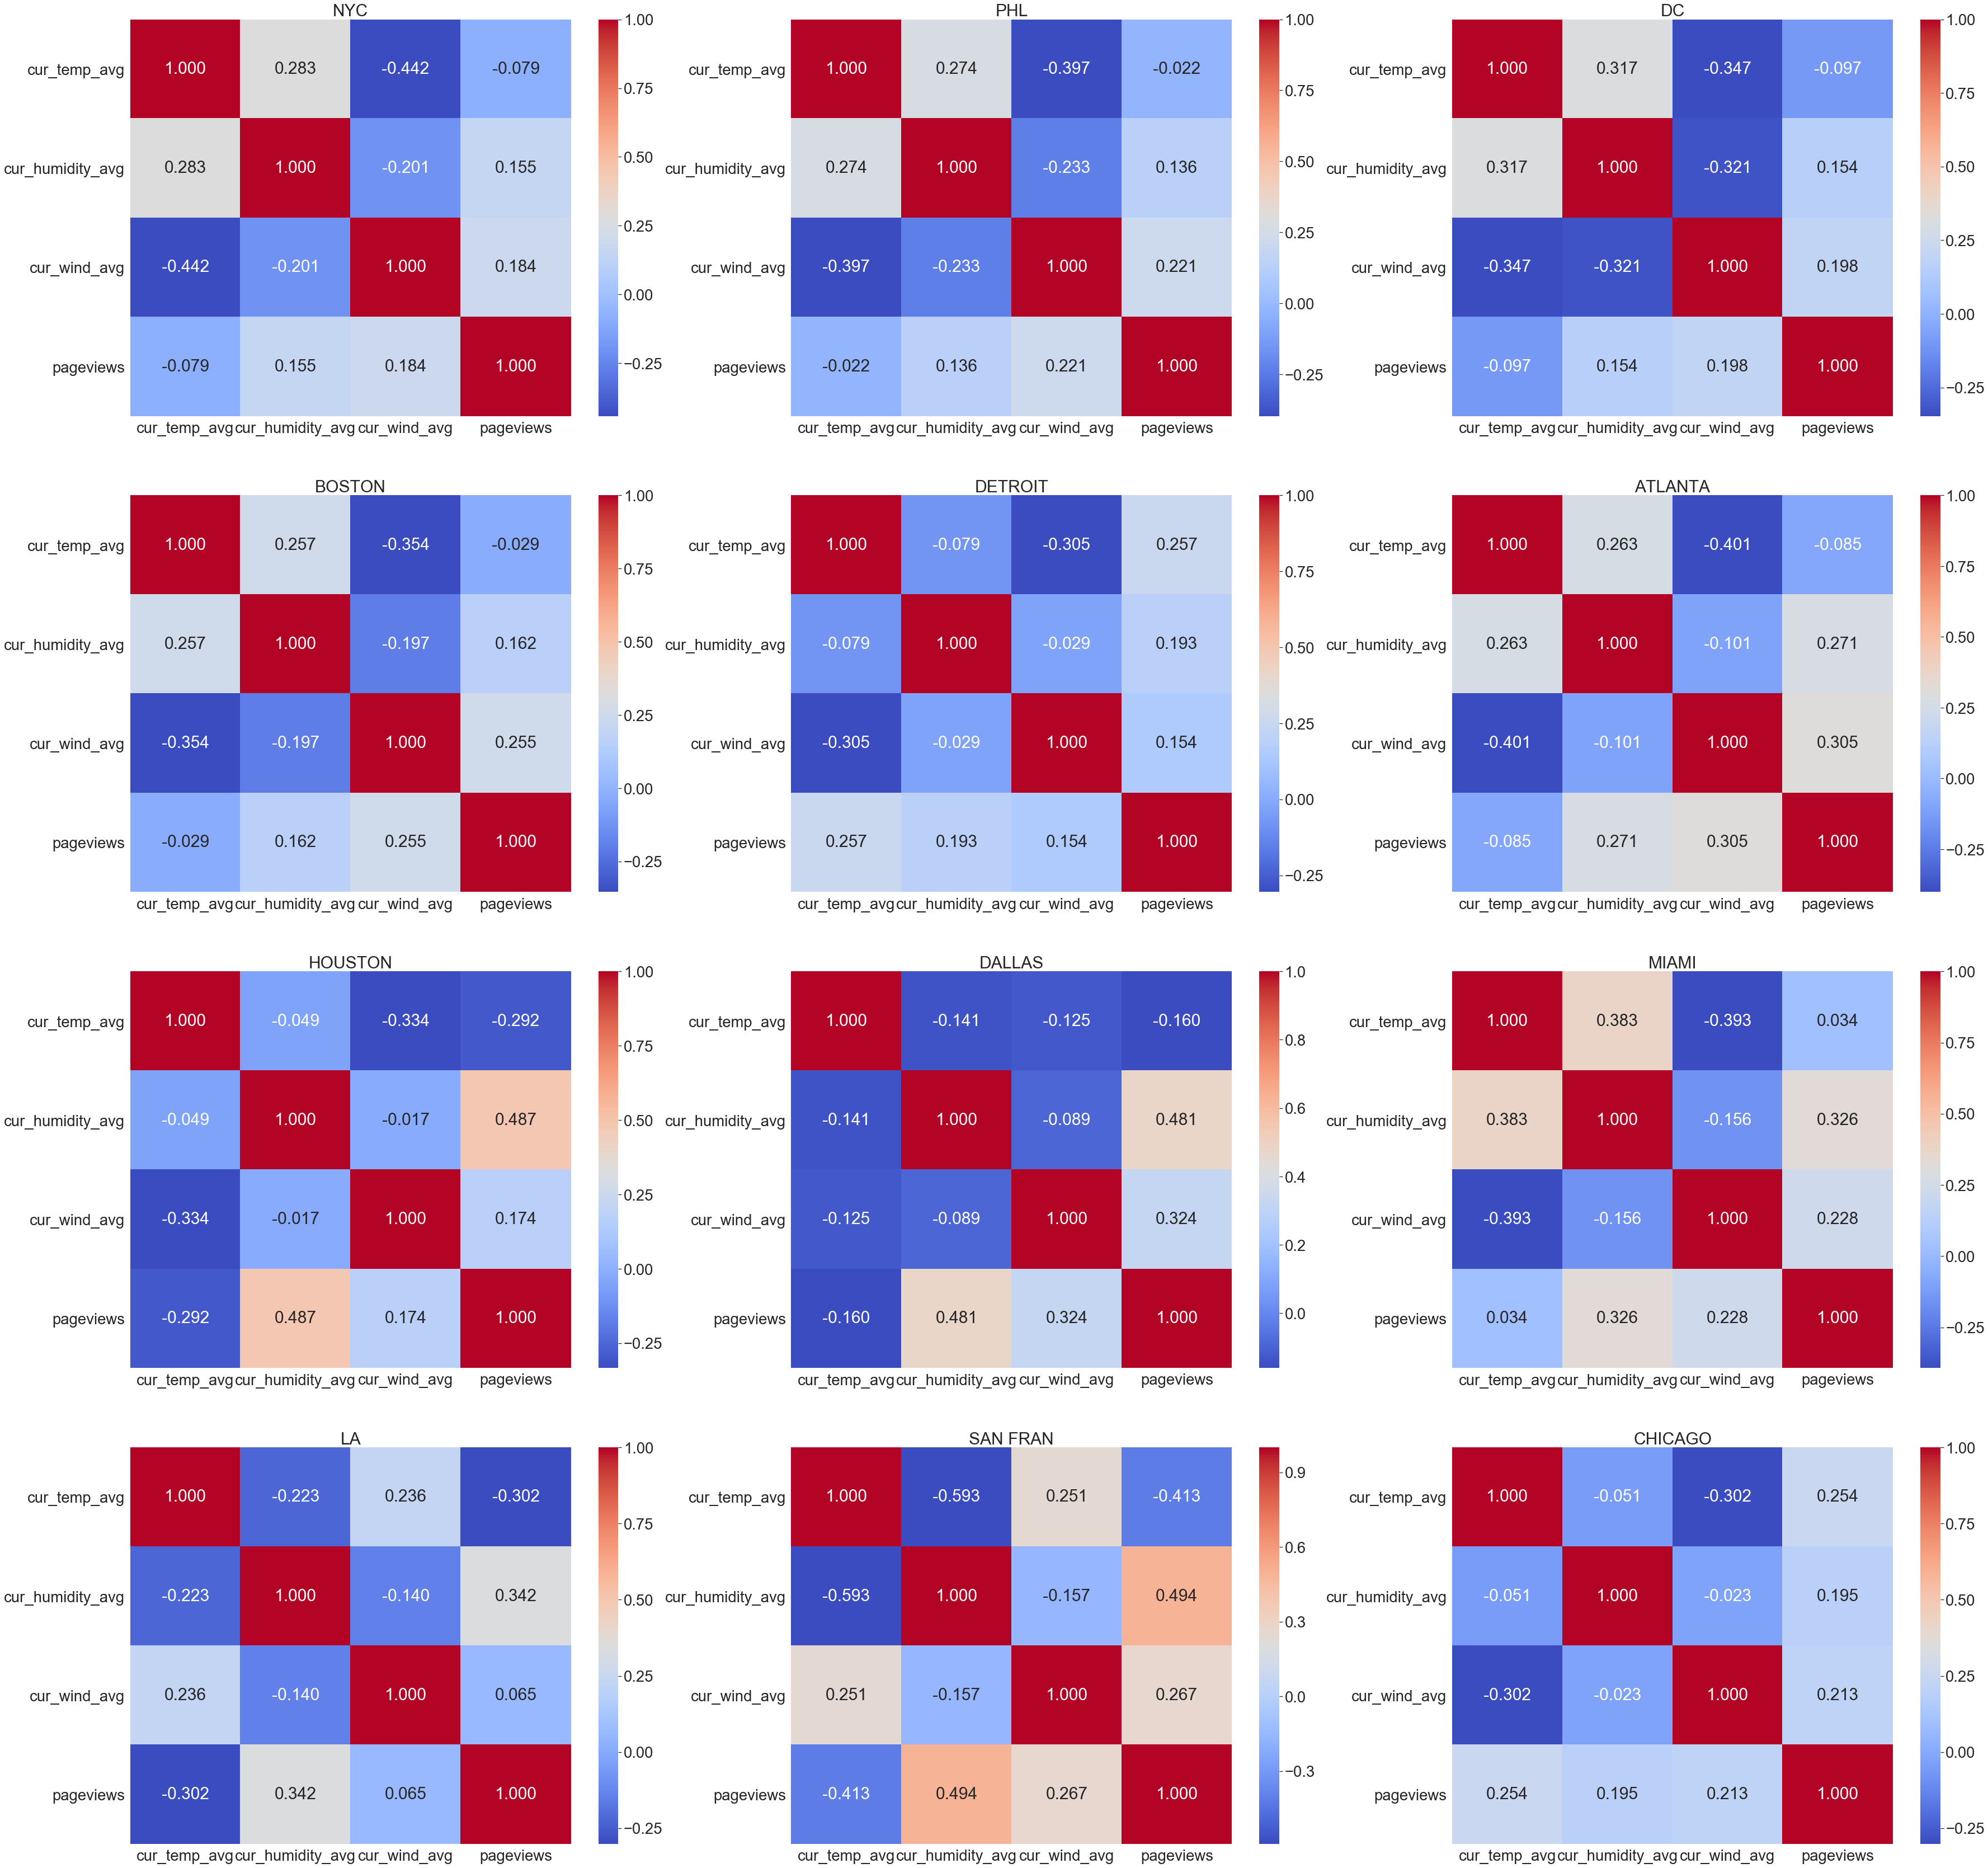

In [20]:
sb.set(style='white',palette='muted',color_codes=True,font_scale=2.5)
f,axes=plt.subplots(4,3,figsize=(60,60),sharex=False)

ny=sb.heatmap(nyc.corr(),annot=True,fmt='.3f',cmap='coolwarm',ax=axes[0,0])
ny.set_title('NYC')
# ny.set_xaxis_ticks_position('top')
phi=sb.heatmap(phil.corr(),annot=True,fmt='.3f',cmap='coolwarm',ax=axes[0,1])
phi.set_title('PHL')
d=sb.heatmap(dc.corr(),annot=True,fmt='.3f',cmap='coolwarm',ax=axes[0,2])
d.set_title('DC')

bo=sb.heatmap(bos.corr(),annot=True,fmt='.3f',cmap='coolwarm',ax=axes[1,0])
bo.set_title('BOSTON')
# ny.set_xaxis_ticks_position('top')
de=sb.heatmap(det.corr(),annot=True,fmt='.3f',cmap='coolwarm',ax=axes[1,1])
de.set_title('DETROIT')
at=sb.heatmap(atl.corr(),annot=True,fmt='.3f',cmap='coolwarm',ax=axes[1,2])
at.set_title('ATLANTA')

ho=sb.heatmap(hou.corr(),annot=True,fmt='.3f',cmap='coolwarm',ax=axes[2,0])
ho.set_title('HOUSTON')
# ny.set_xaxis_ticks_position('top')
da=sb.heatmap(dal.corr(),annot=True,fmt='.3f',cmap='coolwarm',ax=axes[2,1])
da.set_title('DALLAS')
mi=sb.heatmap(mia.corr(),annot=True,fmt='.3f',cmap='coolwarm',ax=axes[2,2])
mi.set_title('MIAMI')

l=sb.heatmap(la.corr(),annot=True,fmt='.3f',cmap='coolwarm',ax=axes[3,0])
l.set_title('LA')
# ny.set_xaxis_ticks_position('top')
s=sb.heatmap(sf.corr(),annot=True,fmt='.3f',cmap='coolwarm',ax=axes[3,1])
s.set_title('SAN FRAN')
ch=sb.heatmap(chi.corr(),annot=True,fmt='.3f',cmap='coolwarm',ax=axes[3,2])
ch.set_title('CHICAGO')

plt.savefig('heatmap_bymetro.jpg')

In [21]:
# wx_pv=pd.read_csv('wx_pv2018.csv')

# wx_pv['pageviews']=wx_pv['pageviews'].apply('{0:,.0f}'.format) #this has turned the numeric column to strings
# wx_pv.head()
# wx_pv.to_csv('wx_pv2018.csv',index=False)

### Check if top 12 metros is accuweather's top metros: they are within top 20 of accuweather's metros

In [22]:
wx_pv=pd.read_csv('wx_pv2018.csv')
# wx_pv['pageviews']=wx_pv['pageviews'].str.replace(',','').astype('int64') this will convert back the string to numeric
df1=wx_pv[['metro','pageviews']]
df1.head()
metro_df=df1.groupby('metro').sum().reset_index()
metro_df.sort_values('pageviews',ascending=False,inplace=True)
metro_t12=metro_df.head(12) 
# wx_pv.dtypes

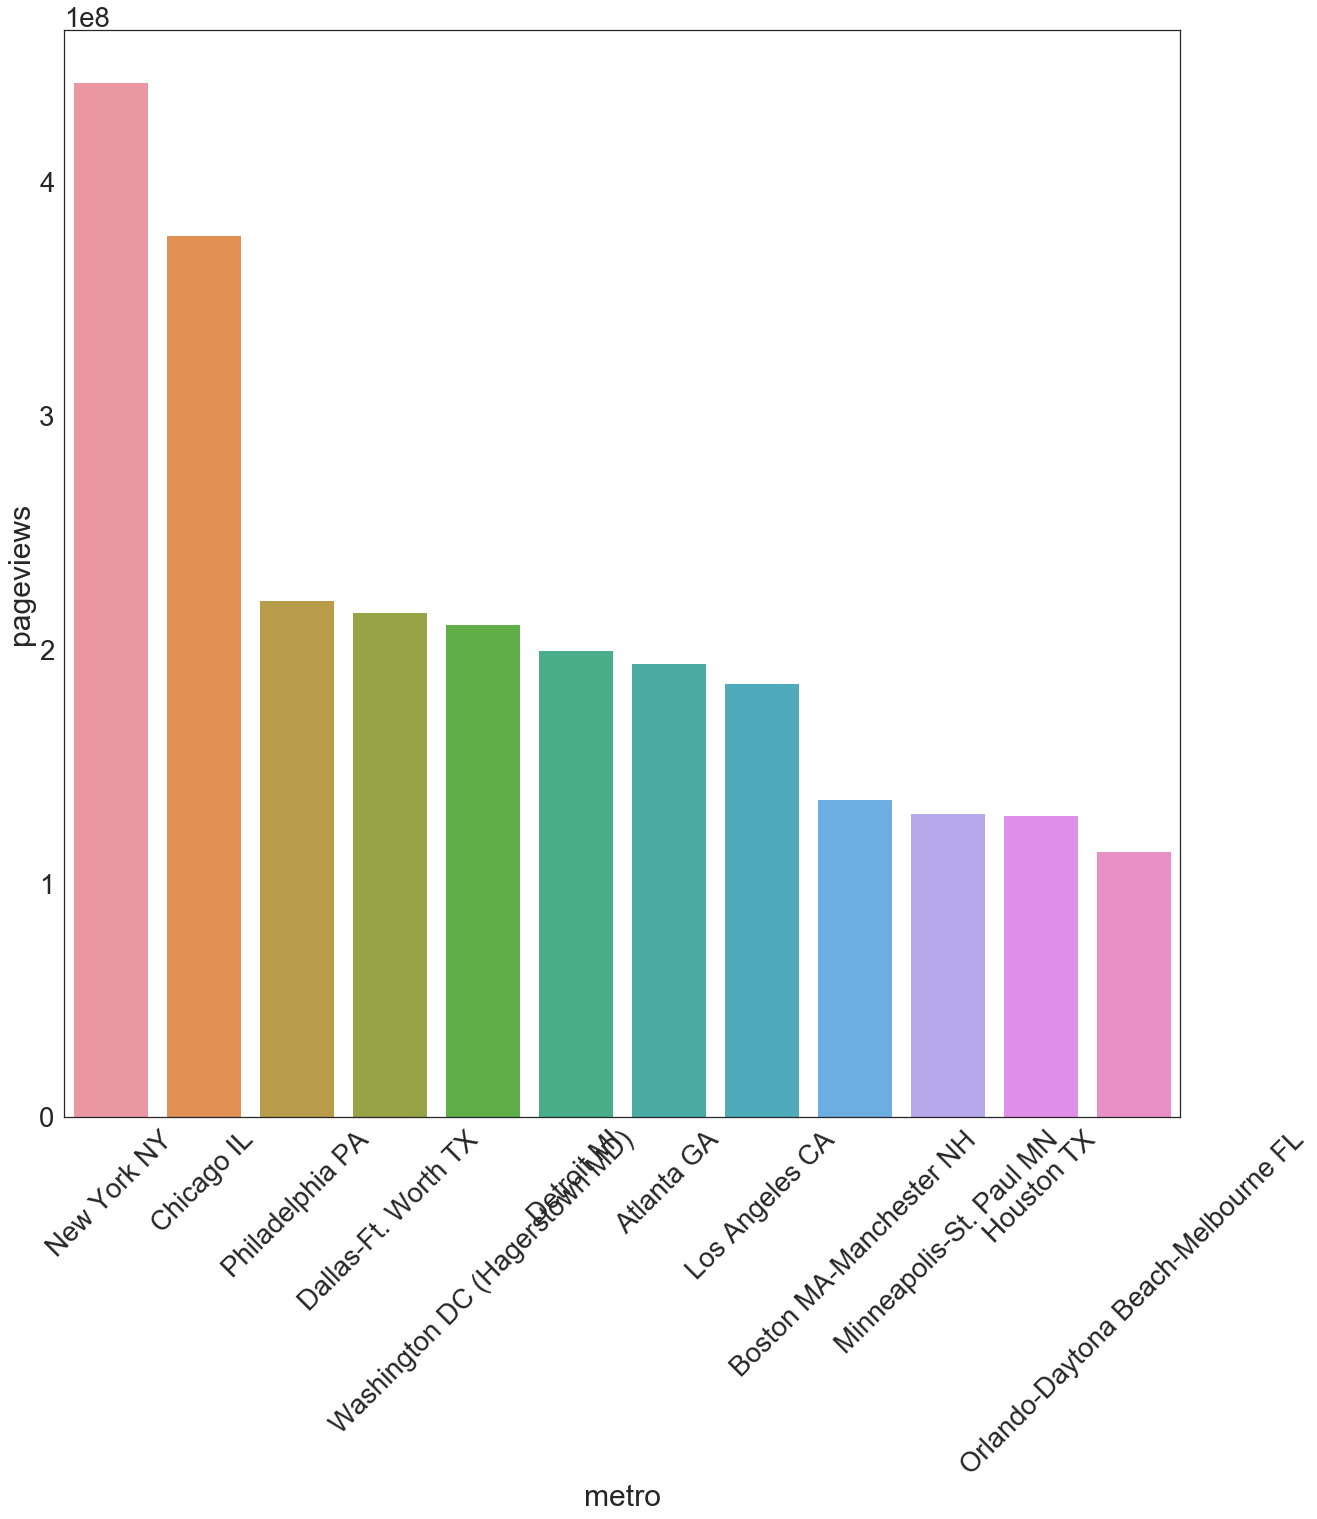

In [23]:
f,axes=plt.subplots(figsize=(20,20))
t=sb.barplot(x=metro_t12['metro'],y=metro_t12['pageviews'])
t.tick_params(axis='x',rotation=45) 
# plt.xticks(rotation=45)

### Feature engineering

#### binary coding for temp, humidity, wind based on EDA
1. for temp, we see some dividing point such as 40, 50, 60, 65, 70,80,
2. for humidity, we see some of the dividing points are 60, 70, 75, 80
3. fir wund, dividing points are 5, 7.5
4. also coded for seasonal features such as weekly day, day of the month and month
5. code for 15 major holidays: 12 federal holidays and some big social events such as valentines's day, easter day, super bowl day 

In [24]:
wx_pv.shape #(76604, 7)
wx_pv=pd.read_csv('wx_pv2018.csv')
conditions=[(wx_pv['cur_temp_avg']<40),
            (wx_pv['cur_temp_avg']<50) & (wx_pv['cur_temp_avg']>=40),
            (wx_pv['cur_temp_avg']<60) & (wx_pv['cur_temp_avg']>=50),
           (wx_pv['cur_temp_avg']<65) & (wx_pv['cur_temp_avg']>=60),
           (wx_pv['cur_temp_avg']<70) & (wx_pv['cur_temp_avg']>=65),
           (wx_pv['cur_temp_avg']<80) & (wx_pv['cur_temp_avg']>=70),
           (wx_pv['cur_temp_avg']<90) & (wx_pv['cur_temp_avg']>=80),
           (wx_pv['cur_temp_avg']>=90)]
# try not to use > and < signs as XGBoost algorithm complains about them
choices=['LT40','40_50','50_60','60_65','65_70','70_80','80_90','GT90']
wx_pv['temp_cat']=np.select(conditions, choices)


cond_hum=[(wx_pv['cur_humidity_avg']<60),
            (wx_pv['cur_humidity_avg']<70) & (wx_pv['cur_humidity_avg']>=60),
            (wx_pv['cur_humidity_avg']<75) & (wx_pv['cur_humidity_avg']>=70),
           (wx_pv['cur_humidity_avg']<80) & (wx_pv['cur_humidity_avg']>=75),
           (wx_pv['cur_humidity_avg']>=80)]
cho_hum=['LT60','60_70','70_75','75_80','GT80']
wx_pv['hum_cat']=np.select(cond_hum,cho_hum)


cond_wind=[(wx_pv['cur_wind_avg']<5),
            (wx_pv['cur_wind_avg']<7.5) & (wx_pv['cur_wind_avg']>=5),
            (wx_pv['cur_wind_avg']>=7.5)]
cho_wind=['LT5','5_7.5','GT7.5']
wx_pv['wind_cat']=np.select(cond_wind,cho_wind)


wx_pv['date']=pd.to_datetime(wx_pv['date'])
wx_pv['day_of_week'] = wx_pv['date'].dt.weekday
wx_pv['day_of_month'] = wx_pv['date'].dt.day
wx_pv['month'] = wx_pv['date'].dt.month

cond_hol=[(wx_pv['date']>='2018-01-01') & (wx_pv['date']<='2018-01-07'),#2018-01-01
          (wx_pv['date']>='2018-01-12') & (wx_pv['date']<='2018-01-18'),#2018-01-15
          (wx_pv['date']>='2018-02-11') & (wx_pv['date']<='2018-02-17'),#2018-02-14
          (wx_pv['date']>='2018-02-16') & (wx_pv['date']<='2018-02-22')#2018-02-19
         ,(wx_pv['date']>='2018-03-29') & (wx_pv['date']<='2018-04-04'),#2018-04-01
          (wx_pv['date']>='2018-05-25') & (wx_pv['date']<='2018-05-31'),#2018-05-28
          (wx_pv['date']>='2018-02-01') & (wx_pv['date']<='2018-02-07'),#2018-02-04
          (wx_pv['date']>='2018-07-01') & (wx_pv['date']<='2018-07-07')#2018-07-04
         ,(wx_pv['date']>='2018-08-31') & (wx_pv['date']<='2018-09-06'),#2018-09-03
          (wx_pv['date']>='2018-10-05') & (wx_pv['date']<='2018-10-11'),#20118-10-08
          (wx_pv['date']>='2018-11-09') & (wx_pv['date']<='2018-11-15'),#2018-11-12
          (wx_pv['date']>='2018-11-15') & (wx_pv['date']<='2018-11-29') #2018-11-22
         ,(wx_pv['date']>='2018-12-20') & (wx_pv['date']<='2018-12-31')]#2018-12-25
cho_hol=['new_year','MLK','Valentine','GW_Bday','easter','memorial','super_bowl','jul4th',
         'labor_day','columbus_day','veteran','thanksgiving','xmas']
wx_pv['holidays']=np.select(cond_hol,cho_hol)

cond_sea =[
    (wx_pv['month']==1 )| (wx_pv['month']==12)| (wx_pv['month']==2),
    (wx_pv['month']==3) | (wx_pv['month']==4) | ( wx_pv['month']==5),
    (wx_pv['month']==6) | (wx_pv['month']==7) | (wx_pv['month']==8),
    (wx_pv['month']==9)|(wx_pv['month']==10)| (wx_pv['month']==11),
   ]
cho_sea = ['Winter', 'Spring', 'Summer','Fall']
wx_pv['season']= np.select(cond_sea, cho_sea)

wx_pv.to_csv('wx_pv_cat.csv',index=False)
wx_pv=pd.get_dummies(wx_pv, columns=['temp_cat','hum_cat','wind_cat','day_of_week','day_of_month','month','holidays','season'])
wx_pv.to_csv('wx_pv_binCode.csv',index=False)
wx_pv.shape #(76604, 72)

(76604, 91)

In [25]:
wx_pv=pd.read_csv('wx_pv_binCode.csv')
wx_pv.head()

# wx_pv['holidays'].unique()

,Unnamed: 0,date,metro,cur_temp_avg,cur_humidity_avg,cur_wind_avg,pageviews,temp_cat_40_50,temp_cat_50_60,temp_cat_60_65,...,holidays_memorial,holidays_new_year,holidays_super_bowl,holidays_thanksgiving,holidays_veteran,holidays_xmas,season_Fall,season_Spring,season_Summer,season_Winter
0,0,2018-07-26,Cedar Rapids-Waterloo-Iowa City & Dubuque IA,70.975,72.655,9.070,20307,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,2018-11-18,Denver CO,34.232,68.920,4.834,157006,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,2,2018-07-11,Idaho Falls-Pocatello ID,77.425,38.650,9.050,2962,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,2018-06-06,Detroit MI,62.920,62.483,5.646,471089,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,4,2018-08-08,Portland-Auburn ME,78.583,80.242,4.385,62576,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Modeling for Regression Problem

#### Overall Model
+ not very good result on rmse and r2

In [26]:
def models(x,y):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)
    ago1=SVR()
    ago2=LinearRegression()
    ago3=Ridge()
    ago4=Lasso()
    ago5=ElasticNet()
    ago6=BayesianRidge()
    ago7=DecisionTreeRegressor()
    ago8=RandomForestRegressor()
    ago9=xgb.XGBRegressor()
    model_name_list=['SVR','Linear Regression','Ridge','Lasso','ElasticNet','BayesianRidge','DecisionTree','RandomForest','XGB']
    
    results=pd.DataFrame(columns=['rmse','r2'],index=model_name_list)
    for i, ago in enumerate([ago1,ago2,ago3,ago4,ago5,ago6,ago7,ago8,ago9]):
        model=ago.fit(x_train,y_train)
        y_pred=model.predict(x_test)
        
        rmse=np.sqrt(np.mean((y_pred-y_test)**2))
        r2=r2_score(y_test,y_pred)
        model_name=model_name_list[i]
        results.ix[model_name,:]=[rmse,r2] #.ix mainly label based index, iloc is integer based index
        
    return results

#### Algorithm learning

1. convert metro labels into numerical categories as another feature
2. tried LR algorithm first and got rmse, r2 of (164916.138, 0.0163) 
3. try to normalize, standardscale the features, it didn't work either, didn't get r2 improved
4. tried decision tree and random forest, has huge improve on rmse and r2: DT: (111679.699, 0.54889), RF: (97151.718, 0.65862)
5. tried to just model on weather variables, RF get (102787.355, 0.61787) for rmse and r2


In [27]:
wx_pv0=pd.read_csv('wx_pv_cat.csv')
le=LabelEncoder()
wx_pv0['temp_cat']=le.fit_transform(wx_pv0['temp_cat']) #choices=['<40','40_50','50_60','60_65','65_70','70_80','80_90','>=90']
le_temp_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
wx_pv0['hum_cat']=le.fit_transform(wx_pv0['hum_cat']) #cho_hum=['<60','60_70','70_75','75_80','>=80']
le_hum_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
wx_pv0['wind_cat']=le.fit_transform(wx_pv0['wind_cat']) #cho_wind=['<5','5_7.5','>=7.5']
# wx_pv0.head()
le_wind_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
wx_pv0['metro_cat']=le.fit_transform(wx_pv0['metro'])
le_metro_mapping=dict(zip(le.classes_,le.transform(le.classes_)))

wx_pv0['holidays']=le.fit_transform(wx_pv0['holidays'])
le_hol_mapping=dict(zip(le.classes_,le.transform(le.classes_)))
# le.get_params

wx_pv0['season']=le.fit_transform(wx_pv0['season'])
le_sea_mapping=dict(zip(le.classes_,le.transform(le.classes_)))
wx_pv0.to_csv('wx_pv_cat_forTrain.csv',index=False)
(le_temp_mapping, le_hum_mapping,le_wind_mapping,le_metro_mapping,le_hol_mapping,le_sea_mapping)

({'40_50': 0,
  '50_60': 1,
  '60_65': 2,
  '65_70': 3,
  '70_80': 4,
  '80_90': 5,
  'GT90': 6,
  'LT40': 7},
 {'60_70': 0, '70_75': 1, '75_80': 2, 'GT80': 3, 'LT60': 4},
 {'5_7.5': 0, 'GT7.5': 1, 'LT5': 2},
 {'Abilene-Sweetwater TX': 0,
  'Albany GA': 1,
  'Albany-Schenectady-Troy NY': 2,
  'Albuquerque-Santa Fe NM': 3,
  'Alexandria LA': 4,
  'Alpena MI': 5,
  'Amarillo TX': 6,
  'Anchorage AK': 7,
  'Atlanta GA': 8,
  'Augusta GA': 9,
  'Austin TX': 10,
  'Bakersfield CA': 11,
  'Baltimore MD': 12,
  'Bangor ME': 13,
  'Baton Rouge LA': 14,
  'Beaumont-Port Arthur TX': 15,
  'Bend OR': 16,
  'Billings, MT': 17,
  'Biloxi-Gulfport MS': 18,
  'Binghamton NY': 19,
  'Birmingham (Ann and Tusc) AL': 20,
  'Bluefield-Beckley-Oak Hill WV': 21,
  'Boise ID': 22,
  'Boston MA-Manchester NH': 23,
  'Bowling Green KY': 24,
  'Buffalo NY': 25,
  'Burlington VT-Plattsburgh NY': 26,
  'Butte-Bozeman MT': 27,
  'Casper-Riverton WY': 28,
  'Cedar Rapids-Waterloo-Iowa City & Dubuque IA': 29,
  'Cha

#### try linear regression algorithm

In [28]:
# with metro
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date','Unnamed: 0'],axis=1)
y=wx_pv0['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)
scaler=StandardScaler() #no difference without standardscaler
xs_train=scaler.fit_transform(x_train)
xs_test=scaler.fit_transform(x_test)
lr=LinearRegression()
model=lr.fit(xs_train,y_train)
y_pred=model.predict(xs_test)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
(round(rmse,3),round(r2,5))
coef_df=pd.DataFrame({'Predictors': list(x.columns), 'Coef_abs': list(abs(model.coef_)),'Coef':list(model.coef_)}) #69
coef_df.sort_values('Coef_abs',ascending=False)

,Predictors,Coef_abs,Coef
8,month,15834.166819,-15834.166819
1,cur_humidity_avg,14001.141024,14001.141024
0,cur_temp_avg,9060.491218,9060.491218
2,cur_wind_avg,8659.770709,8659.770709
5,wind_cat,6042.021204,-6042.021204
11,metro_cat,4694.150715,-4694.150715
7,day_of_month,4476.743287,-4476.743287
9,holidays,3534.664134,3534.664134
6,day_of_week,825.678985,-825.678985
10,season,796.155631,-796.155631


In [29]:
(round(rmse,3),round(r2,5))#(164916.138, 0.0163)
# x.columns

(164918.911, 0.01627)

In [30]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
wx_pv0['month'].unique()

array([ 7, 11,  6,  8,  2,  5,  3,  4,  1, 10,  9, 12], dtype=int64)

#### decision tree algorithm

In [31]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date','Unnamed: 0'],axis=1)
y=wx_pv0['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)
# scaler=StandardScaler()
# xs_train=scaler.fit_transform(x_train)
# xs_test=scaler.fit_transform(x_test)
dt=DecisionTreeRegressor()
model=dt.fit(xs_train,y_train)
y_pred=model.predict(xs_test)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
(round(rmse,3),round(r2,5)) #(111679.699, 0.54889),(109117.343, 0.56935)
# coef_df=pd.DataFrame({'Predictors': list(x.columns), 'Coef_abs': list(abs(model.coef_)),'Coef':list(model.coef_)}) #69
# coef_df.sort_values('Coef_abs',ascending=False)

(110491.457, 0.55844)

#### random forest tree regressor

In [32]:
wx_pv0.shape #(76604, 16)
wx_pv0.columns

Index(['Unnamed: 0', 'date', 'metro', 'cur_temp_avg', 'cur_humidity_avg',
       'cur_wind_avg', 'pageviews', 'temp_cat', 'hum_cat', 'wind_cat',
       'day_of_week', 'day_of_month', 'month', 'holidays', 'season',
       'metro_cat'],
      dtype='object')

In [33]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date','Unnamed: 0'],axis=1)
y=wx_pv0['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)
# scaler=StandardScaler()
# xs_train=scaler.fit_transform(x_train)
# xs_test=scaler.fit_transform(x_test)
rf=RandomForestRegressor(random_state=888,n_estimators=20)
model=rf.fit(x_train,y_train)
y_pred=model.predict(x_test)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
(round(rmse,3),round(r2,5)) #(63537.522, 0.85399)
# coef_df=pd.DataFrame({'Predictors': list(x.columns), 'Coef_abs': list(abs(model.coef_)),'Coef':list(model.coef_)}) #69
# coef_df.sort_values('Coef_abs',ascending=False)

(63537.522, 0.85399)

In [34]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date','Unnamed: 0','temp_cat', 'hum_cat', 'wind_cat'],axis=1)
# ,'temp_cat', 'hum_cat', 'wind_cat'
y=wx_pv0['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)
# scaler=StandardScaler()
# xs_train=scaler.fit_transform(x_train)
# xs_test=scaler.fit_transform(x_test)
rf=RandomForestRegressor(random_state=888,n_estimators=20,max_features=9)
model=rf.fit(x_train,y_train)
y_pred=model.predict(x_test)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
(round(rmse,3),round(r2,5)) #(63815.931, 0.8527)
# coef_df=pd.DataFrame({'Predictors': list(x.columns), 'Coef_abs': list(abs(model.coef_)),'Coef':list(model.coef_)}) #69
# coef_df.sort_values('Coef_abs',ascending=False)

(63815.931, 0.8527)

In [35]:

pred_df=pd.DataFrame({'Pred_value':y_pred,'Actual_value':y_test,
                      'Diff%':round((y_pred-y_test)/y_test*100,2),"abs_diff%":abs(round((y_pred-y_test)*100/y_test,2))})

pred_index=pd.merge(wx_pv0,pred_df,how='right',left_index=True,right_index=True)
pred_index.to_csv('overall_model_pred_rf.csv')
round(pred_df['abs_diff%'].mean(),2) #85.57%,24.24

85.57

#### Backward modeling for random forest: 
+ only weather variable: 'cur_temp_avg', 'cur_humidity_avg', 'cur_wind_avg': (175102.739, -0.10897)
+ wx+wx_cat: (173864.948, -0.09335)
+ wx+ wx_cat+metro:(73221.269, 0.80609)
+ wx+ wx_cat+metro+holidays: (71768.29, 0.81371)

In [36]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date','temp_cat',
       'hum_cat', 'wind_cat', 'day_of_week', 'day_of_month', 'month','holidays','metro_cat','Unnamed: 0','season'],axis=1)
y=wx_pv0['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)
rf=RandomForestRegressor(random_state=888,n_estimators=20)
model=rf.fit(x_train,y_train)
y_pred=model.predict(x_test)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
(round(rmse,3),round(r2,5)) #(175102.739, -0.10897)

(175102.739, -0.10897)

In [37]:
x.columns

Index(['cur_temp_avg', 'cur_humidity_avg', 'cur_wind_avg'], dtype='object')

##### wx+ wx categories

In [38]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date', 'day_of_week', 'day_of_month', 'month','holidays','metro_cat','Unnamed: 0','season'],axis=1)
y=wx_pv0['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)
rf=RandomForestRegressor(random_state=888,n_estimators=20)
model=rf.fit(x_train,y_train)
y_pred=model.predict(x_test)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
(round(rmse,3),round(r2,5)) #(173864.948, -0.09335)

(173864.948, -0.09335)

##### wx+wx categories+metro

In [39]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date', 'day_of_week', 'day_of_month', 'month','holidays','Unnamed: 0','season'],axis=1)
y=wx_pv0['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)
rf=RandomForestRegressor(random_state=888,n_estimators=20)
model=rf.fit(x_train,y_train)
y_pred=model.predict(x_test)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
pred_df=pd.DataFrame({'Pred_value':y_pred,'Actual_value':y_test,
                      'Diff%':round((y_pred-y_test)/y_test*100,2),"abs_diff%":abs(round((y_pred-y_test)*100/y_test,2))})
# pred_df.to_csv('overall_model_pred_rf.csv')
diff=round(pred_df['abs_diff%'].mean(),2) #52.83%
(round(rmse,3),round(r2,5),diff) #(73221.269, 0.80609,57.21%)

(73221.269, 0.80609, 57.21)

In [40]:
pred_df=pd.DataFrame({'Pred_value':y_pred,'Actual_value':y_test,
                      'Diff%':round((y_pred-y_test)/y_test*100,2),"abs_diff%":abs(round((y_pred-y_test)*100/y_test,2))})
pred_df.to_csv('overall_model_pred_rf.csv')
round(pred_df['abs_diff%'].mean(),2) #52.83%

57.21

##### wx +wx_categories+metro+holidays

In [41]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date', 'day_of_week', 'day_of_month', 'month','Unnamed: 0','season'],axis=1)
y=wx_pv0['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)
rf=RandomForestRegressor(random_state=888,n_estimators=20)
model=rf.fit(x_train,y_train)
y_pred=model.predict(x_test)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
pred_df=pd.DataFrame({'Pred_value':y_pred,'Actual_value':y_test,
                      'Diff%':round((y_pred-y_test)/y_test*100,2),"abs_diff%":abs(round((y_pred-y_test)*100/y_test,2))})
# pred_df.to_csv('overall_model_pred_rf.csv')
diff=round(pred_df['abs_diff%'].mean(),2) #52.83%
(round(rmse,3),round(r2,5),diff) #(71768.29, 0.81371,52.83%)


(71768.29, 0.81371, 52.83)

##### wx +wx_categories+metro+holidays+week days

In [42]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date', 'day_of_month', 'month','Unnamed: 0','season'],axis=1)
y=wx_pv0['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)
rf=RandomForestRegressor(random_state=888,n_estimators=20)
model=rf.fit(x_train,y_train)
y_pred=model.predict(x_test)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
pred_df=pd.DataFrame({'Pred_value':y_pred,'Actual_value':y_test,
                      'Diff%':round((y_pred-y_test)/y_test*100,2),"abs_diff%":abs(round((y_pred-y_test)*100/y_test,2))})
# pred_df.to_csv('overall_model_pred_rf.csv')
diff=round(pred_df['abs_diff%'].mean(),2) 
(round(rmse,3),round(r2,5),diff) #(71715.045, 0.81398, 51.3)


(71715.045, 0.81398, 51.3)

##### wx +wx_categories+metro+holidays+week days+day of month: (72805.064, 0.80828, 52.81)

In [43]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date',  'month','Unnamed: 0','season'],axis=1)
y=wx_pv0['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)
rf=RandomForestRegressor(random_state=888,n_estimators=20)
model=rf.fit(x_train,y_train)
y_pred=model.predict(x_test)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
pred_df=pd.DataFrame({'Pred_value':y_pred,'Actual_value':y_test,
                      'Diff%':round((y_pred-y_test)/y_test*100,2),"abs_diff%":abs(round((y_pred-y_test)*100/y_test,2))})
# pred_df.to_csv('overall_model_pred_rf.csv')
diff=round(pred_df['abs_diff%'].mean(),2) 
(round(rmse,3),round(r2,5),diff) #(72805.064, 0.80828, 52.81)


(72805.064, 0.80828, 52.81)

##### wx +wx_categories+metro+holidays+week days+day of month+season: (70448.984, 0.82049, 50.13)

In [44]:
def rf_function(x,y):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)
    rf=RandomForestRegressor(random_state=888,n_estimators=20)
    model=rf.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    rmse=np.sqrt(np.mean((y_pred-y_test)**2))
    r2=r2_score(y_test,y_pred)
    pred_df=pd.DataFrame({'Pred_value':y_pred,'Actual_value':y_test,
                          'Diff%':round((y_pred-y_test)/y_test*100,2),"abs_diff%":abs(round((y_pred-y_test)*100/y_test,2))})
    # pred_df.to_csv('overall_model_pred_rf.csv')
    diff=round(pred_df['abs_diff%'].mean(),2) 
    print((round(rmse,3),round(r2,5),diff))

In [45]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date',  'month','Unnamed: 0'],axis=1)
y=wx_pv0['pageviews']
rf_function(x,y) #(70448.984, 0.82049, 50.13)

(70448.984, 0.82049, 50.13)


##### wx +wx_categories+metro+holidays+week days+day of month+season+month: (63537.522, 0.85399, 78.21)

In [46]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date', 'Unnamed: 0'],axis=1)
y=wx_pv0['pageviews']
rf_function(x,y) #(70448.984, 0.82049, 50.13)#(63537.522, 0.85399, 78.21)

(63537.522, 0.85399, 78.21)


##### wx +wx_categories+metro+holidays+week days+season: (68422.597, 0.83067, 49.81)

In [47]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date', 'Unnamed: 0','month','day_of_month'],axis=1)
y=wx_pv0['pageviews']
rf_function(x,y) #(68422.597, 0.83067, 49.81)
pred_df.to_csv('overall_model_pred_rf.csv')

(68422.597, 0.83067, 49.81)


In [48]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date', 'Unnamed: 0','temp_cat',
       'hum_cat', 'wind_cat','month','day_of_month'],axis=1)
y=wx_pv0['pageviews']
rf_function(x,y) #(69295.33, 0.82632, 49.94)

(69295.33, 0.82632, 49.94)


##### Try gridsearchCV for the refined feature list of random forest algorithm:wx +wx_categories+metro+holidays+week days+season

##### Try just top 12 metros: less data and less categories for metro:(221345.594, 0.69641, 28.31)

In [49]:
wx_pv=pd.read_csv('wx_pv_cat_forTrain.csv')
top12=wx_pv[wx_pv['metro'].isin(['Chicago IL','New York NY','Los Angeles CA','Dallas-Ft. Worth TX','Philadelphia PA',
'Houston TX','Washington DC (Hagerstown MD)','Miami-Ft. Lauderdale FL','Atlanta GA','Boston MA-Manchester NH',
'San Francisco-Oakland-San Jose CA','Detroit MI'])]
top12.shape #(4380, 16)


x=top12.drop(['pageviews','metro','date', 'Unnamed: 0','temp_cat',
       'hum_cat', 'wind_cat','month','day_of_month'],axis=1)
y=top12['pageviews']

# pred_df.to_csv('overall_model_pred_rf_top12.csv')

# if cross validated, we get below results: 

rf=RandomForestRegressor(random_state=888,n_estimators=20)
str_kfold=KFold(n_splits=10,random_state=100)
results=cross_val_score(rf,x, y,cv=str_kfold,scoring='neg_mean_squared_error')

round(np.sqrt(abs(results.mean())),3) #236589.987

rf_function(x,y) #(221345.594 0.69641 28.31)

(221345.594, 0.69641, 28.31)


##### Try top 5 metros, reduced r2 and increased rmse: (376193.425, 0.49361, 26.65)

In [50]:
wx_pv=pd.read_csv('wx_pv_cat_forTrain.csv')
top5=wx_pv[wx_pv['metro'].isin(['Chicago IL','New York NY','Dallas-Ft. Worth TX','Philadelphia PA',
'Washington DC (Hagerstown MD)'])]
top5.shape #(4380, 16)


x=top5.drop(['pageviews','metro','date', 'Unnamed: 0','temp_cat',
       'hum_cat', 'wind_cat','month','day_of_month'],axis=1)
y=top5['pageviews']
rf_function(x,y) #(376193.425 0.49361 26.65)

(376193.425, 0.49361, 26.65)


##### Try cross validation for top 5 metros

In [51]:
wx_pv=pd.read_csv('wx_pv_cat_forTrain.csv')
top5=wx_pv[wx_pv['metro'].isin(['Chicago IL','New York NY','Dallas-Ft. Worth TX','Philadelphia PA',
'Washington DC (Hagerstown MD)'])]
top5.shape #(4380, 16)


x=top5.drop(['pageviews','metro','date', 'Unnamed: 0','temp_cat',
       'hum_cat', 'wind_cat','month','day_of_month'],axis=1)
y=top5['pageviews']
rf=RandomForestRegressor(random_state=888,n_estimators=20)
str_kfold=KFold(n_splits=10,random_state=100)
results=cross_val_score(rf,x, y,cv=str_kfold,scoring='neg_mean_squared_error')

round(np.sqrt(abs(results.mean())),3) #329100.633

329100.633

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [53]:
rf=RandomForestRegressor(random_state=888)
model=rf.fit(xs_train,y_train)
str_tree = export_graphviz(rf, 
   out_file=None, 
   feature_names=x_train.columns, # column names
   filled=True,        
   special_characters=True, 
   rotate=True)

display.display(str_tree)


NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

##### Try  XGBoost algorithm

In [54]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
x=wx_pv0.drop(['pageviews','metro','date','Unnamed: 0','month','day_of_month'],axis=1)
y=wx_pv0['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)
dtrain=xgb.DMatrix(x_train,y_train)
dval=xgb.DMatrix(x_test,y_test)
param={'max_depth':5, 
                'eta':0.15, 
                'silent':1, 
                "objective":"reg:linear",
                "eval_metric":"rmse",
                'subsample': 0.8,
                'maximize': False,
                'colsample_bytree': 0.8,
                'lambda':0.3,
             "gamma":1,
            'random_state':0}
evals=[(dtrain,'train'),(dval,'test')]
model=xgb.train(params=param, dtrain=dtrain, num_boost_round=5000,verbose_eval=100,early_stopping_rounds=500,evals=evals)
y_pred=model.predict(dval,ntree_limit=model.best_ntree_limit)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
print((round(rmse,3),round(r2,5)) )#((64547.392, 0.84931),ES=500,eta=0.15),((66067.662, 0.84213), eta=0.15, ES=50),(63742.9, 0.85304,es=500 with lambda=0.3,gamma=1)
pred_df=pd.DataFrame({'Pred_value':y_pred,'Actual_value':y_test,
                      'Diff%':round((y_pred-y_test)/y_test*100,2),"abs_diff%":abs(round((y_pred-y_test)/y_test*100,2))})
pred_df.to_csv('overall_model_pred.csv')
print(round(pred_df['abs_diff%'].mean(),2))

[0]	train-rmse:172267	test-rmse:166566
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 500 rounds.
[100]	train-rmse:60373.3	test-rmse:76602.4
[200]	train-rmse:50927.9	test-rmse:72117.2
[300]	train-rmse:46344.1	test-rmse:70412.9
[400]	train-rmse:43171.7	test-rmse:69981.3
[500]	train-rmse:40498.9	test-rmse:69509.2
[600]	train-rmse:38256.5	test-rmse:69468.3
[700]	train-rmse:36347.2	test-rmse:69388.5
[800]	train-rmse:34853.7	test-rmse:69297.6
[900]	train-rmse:33227.3	test-rmse:69251.4
[1000]	train-rmse:31957	test-rmse:69265.4
[1100]	train-rmse:30670.9	test-rmse:69240.7
[1200]	train-rmse:29461.3	test-rmse:69256.4
[1300]	train-rmse:28434.8	test-rmse:69243.3
[1400]	train-rmse:27450	test-rmse:69293
[1500]	train-rmse:26546.1	test-rmse:69344.5
[1600]	train-rmse:25673.5	test-rmse:69297.9
Stopping. Best iteration:
[1187]	train-rmse:29600.1	test-rmse:69195.5

(69195.315, 0.82682)
371.44


In [55]:

pred_df=pd.DataFrame({'Pred_value':y_pred,'Actual_value':y_test,
                      'Diff%':round((y_pred-y_test)/y_test*100,2),"abs_diff%":abs(round((y_pred-y_test)/y_test*100,2))})
pred_df.to_csv('overall_model_pred.csv')
round(pred_df['abs_diff%'].mean(),2) #207.62%,261.94%

371.44

### Learn on binary features
1. the OneHotEncoded(binary coded) features wouldn't work with the tree-based models b/c tree-based models needs a clear divding (GT,LS) to make decisions. 
2. LR algorithm didn't work either with rmse and r2 of:(164897.973, 0.01652)
3. tried to standard scale, it got bad results (164841.801, 0.01719)



In [56]:
wx_pv=pd.read_csv('wx_pv_binCode.csv')
x=wx_pv.drop(['pageviews','metro','date','Unnamed: 0'],axis=1)
y=wx_pv['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)

lr=LinearRegression(normalize=True)
model=lr.fit(x_train,y_train)
y_pred=model.predict(x_test)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
(round(rmse,3),round(r2,5))
coef_df=pd.DataFrame({'Predictors': list(x.columns), 'Coef_abs': list(abs(model.coef_)),'Coef':list(model.coef_)}) #69
coef_df.sort_values('Coef_abs',ascending=False)

,Predictors,Coef_abs,Coef
18,wind_cat_LT5,5.205633e+18,-5.205633e+18
16,wind_cat_5_7.5,5.205633e+18,-5.205633e+18
17,wind_cat_GT7.5,5.205633e+18,-5.205633e+18
84,season_Spring,3.827311e+18,-3.827311e+18
86,season_Winter,3.272163e+18,-3.272163e+18
85,season_Summer,2.991891e+18,-2.991891e+18
83,season_Fall,2.328542e+18,-2.328542e+18
59,month_3,1.827739e+18,1.827739e+18
61,month_5,1.827739e+18,1.827739e+18
60,month_4,1.827739e+18,1.827739e+18


In [57]:
(round(rmse,3),round(r2,5))

(164825.358, 0.01739)

#### Decistion Tree

In [58]:
wx_pv=pd.read_csv('wx_pv_binCode.csv')
x=wx_pv.drop(['pageviews','metro','date','Unnamed: 0'],axis=1)
y=wx_pv['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)

dt=DecisionTreeRegressor()
model=dt.fit(x_train,y_train)
y_pred=model.predict(x_test)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
(round(rmse,3),round(r2,5)) #(246794.134, -1.20295)

(243951.998, -1.1525)

#### Random Forest for binary features

In [59]:
wx_pv=pd.read_csv('wx_pv_binCode.csv')
wx_pv.columns
# wx_pv.head()

Index(['Unnamed: 0', 'date', 'metro', 'cur_temp_avg', 'cur_humidity_avg',
       'cur_wind_avg', 'pageviews', 'temp_cat_40_50', 'temp_cat_50_60',
       'temp_cat_60_65', 'temp_cat_65_70', 'temp_cat_70_80', 'temp_cat_80_90',
       'temp_cat_GT90', 'temp_cat_LT40', 'hum_cat_60_70', 'hum_cat_70_75',
       'hum_cat_75_80', 'hum_cat_GT80', 'hum_cat_LT60', 'wind_cat_5_7.5',
       'wind_cat_GT7.5', 'wind_cat_LT5', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'day_of_month_1', 'day_of_month_2', 'day_of_month_3',
       'day_of_month_4', 'day_of_month_5', 'day_of_month_6', 'day_of_month_7',
       'day_of_month_8', 'day_of_month_9', 'day_of_month_10',
       'day_of_month_11', 'day_of_month_12', 'day_of_month_13',
       'day_of_month_14', 'day_of_month_15', 'day_of_month_16',
       'day_of_month_17', 'day_of_month_18', 'day_of_month_19',
       'day_of_month_20', 'day_of_month_21', 'day_of_month_22',
 

#### XGBoost with default setting

In [60]:
wx_pv=pd.read_csv('wx_pv_binCode.csv')
x=wx_pv.drop(['pageviews','metro','date','Unnamed: 0'],axis=1)
y=wx_pv['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)

xg=xgb.XGBRegressor()
model=xg.fit(x_train,y_train)
y_pred=model.predict(x_test)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
(round(rmse,3),round(r2,5)) #(163864.902, 0.02881)

[12:44:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(163864.811, 0.02881)

#### XGBoost with specific parameter

In [61]:
wx_pv=pd.read_csv('wx_pv_binCode.csv')
x=wx_pv.drop(['pageviews','metro','date','Unnamed: 0'],axis=1)
y=wx_pv['pageviews']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)
dtrain=xgb.DMatrix(x_train,y_train)
dval=xgb.DMatrix(x_test,y_test)
param={'max_depth':5, 
                'eta':0.15, 
                'silent':1, 
                "objective":"reg:linear",
                "eval_metric":"rmse",
                'subsample': 0.8,
                'maximize': False,
                'colsample_bytree': 0.8,
            'random_state':0}
evals=[(dtrain,'train'),(dval,'test')]
model=xgb.train(params=param, dtrain=dtrain, num_boost_round=5000,verbose_eval=10,early_stopping_rounds=10,evals=evals)
y_pred=model.predict(dval)
rmse=np.sqrt(np.mean((y_pred-y_test)**2))
r2=r2_score(y_test,y_pred)
(round(rmse,3),round(r2,5)) #(166337.14, -0.00072),(163524.813, 0.03283 when early_stopping=50)

[0]	train-rmse:181849	test-rmse:175859
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
[10]	train-rmse:168475	test-rmse:164430
[20]	train-rmse:166397	test-rmse:163898
[30]	train-rmse:165132	test-rmse:163563
Stopping. Best iteration:
[28]	train-rmse:165483	test-rmse:163488



(163615.966, 0.03175)

#### Try cross validation

In [62]:
x=wx_pv0.drop(['pageviews','metro','date'],axis=1)
y=wx_pv0['pageviews']
lr=LinearRegression()

# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=888)

str_kfold=KFold(n_splits=10,random_state=100)
results=cross_val_score(lr,x, y,cv=str_kfold,scoring='neg_mean_squared_error')
# print('accuracy: %.3f (%.3f)') % (results.mean(),results.std())
(results.mean(),results.std()) #(-28892588192.45748, 2827547975.405257)
round(np.sqrt(abs(results.mean())),3) #169229.582

169229.582

### By Metro Model

##### Wrapped in a function

In [63]:
def xgb_metro_model(non_features, data,loop_feat):


    LABEL = 'pageviews'       

    # model each category and check # impressions
    # create feature list for modeling
    varimporder = []
    varitem = []

    FEATURES = [feat for feat in list(data) if feat not in non_features]


    idv_list = []
    target = set(data[loop_feat])
    for item in target:
        tmp_df = data[data[loop_feat]== item]


        print(item)
        idv_list.append(item)
        x_train, x_test, y_train, y_test = train_test_split(tmp_df[FEATURES], tmp_df[LABEL], 
                                                                   test_size=0.2, random_state=42)

        dtrain = xgb.DMatrix(data = x_train,  label = y_train)
        dval = xgb.DMatrix(data = x_test, label = y_test)

        param = {'max_depth':5, 
                    'eta':0.15, 
                    'silent':1, 
                    "objective":"reg:linear",
                    "eval_metric":"rmse",
                    'subsample': 0.8,
                    'maximize': False,
                    'colsample_bytree': 0.8,
                 'lambda':0.5,
                'random_state':0}

        evals = [(dtrain,'train'),(dval,'test')]
        clf = xgb.train ( params = param,
                      dtrain = dtrain,
                      num_boost_round = 5000,
                      verbose_eval=10, 
                      early_stopping_rounds = 50,
                      evals=evals)

        y_pred=clf.predict(dval,ntree_limit=clf.best_ntree_limit)
        rmse=np.sqrt(np.mean((y_pred-y_test)**2))
        r2=r2_score(y_test,y_pred)
        
        importances = clf.get_fscore()
        importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
        importance_frame.sort_values(by = 'Importance', inplace = True, ascending= False)
        print(importance_frame.head(20))

        varitem.append(item)
        varimporder.append(importance_frame['Feature'].values)
        pred_df=pd.DataFrame({'Pred_value':y_pred,'Atual_value':y_test,'Diff%':round((y_pred-y_test)/y_test*100,2),
                              "abs_diff%":abs(round((y_pred-y_test)/y_test*100,2))})
        print((round(rmse,3),round(r2,5),round(pred_df['abs_diff%'].mean(),2)))


In [64]:
non_features=['date', 'metro','pageviews','Unnamed: 0']
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
loop_feat='metro'
xgb_metro_model(non_features,wx_pv0,'metro')

Idaho Falls-Pocatello ID
[0]	train-rmse:4790.6	test-rmse:4442.89
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1346.47	test-rmse:1578.09
[20]	train-rmse:664.593	test-rmse:1244.48
[30]	train-rmse:473.889	test-rmse:1228.89
[40]	train-rmse:386.811	test-rmse:1214.31
[50]	train-rmse:317.75	test-rmse:1203.12
[60]	train-rmse:259.875	test-rmse:1195.34
[70]	train-rmse:212.201	test-rmse:1194.82
[80]	train-rmse:174.437	test-rmse:1193.24
[90]	train-rmse:141.863	test-rmse:1192.72
[100]	train-rmse:111.829	test-rmse:1203.73
[110]	train-rmse:93.2834	test-rmse:1205.41
[120]	train-rmse:77.8021	test-rmse:1205.94
Stopping. Best iteration:
[72]	train-rmse:206.173	test-rmse:1189.55

    Importance           Feature
4          653      cur_temp_avg
5          516  cur_humidity_avg
1          473      cur_wind_avg
6          311      day_of_month
8          163       day_of_week
0          126     

10          17          wind_cat
(1197.978, 0.23252, 36.38)
Portland OR
[0]	train-rmse:101067	test-rmse:82474.4
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:28107.8	test-rmse:23963.7
[20]	train-rmse:13690.3	test-rmse:20920.7
[30]	train-rmse:9607.3	test-rmse:20852.8
[40]	train-rmse:7120.7	test-rmse:20772.3
[50]	train-rmse:5494.62	test-rmse:20916.3
[60]	train-rmse:4235.01	test-rmse:20950.5
[70]	train-rmse:3275.7	test-rmse:20987.5
Stopping. Best iteration:
[25]	train-rmse:11337.2	test-rmse:20641.1

    Importance           Feature
0          347      cur_temp_avg
5          277  cur_humidity_avg
2          272      cur_wind_avg
6          189      day_of_month
1          112             month
8           92       day_of_week
3           42          temp_cat
4           34          holidays
7           22           hum_cat
10          18            season
9           13        

[40]	train-rmse:2334.56	test-rmse:9480.56
[50]	train-rmse:1859.91	test-rmse:9432.3
[60]	train-rmse:1545.68	test-rmse:9507.66
Stopping. Best iteration:
[13]	train-rmse:6241.15	test-rmse:8376.05

    Importance           Feature
0          296      cur_temp_avg
4          256  cur_humidity_avg
1          230      cur_wind_avg
6          167      day_of_month
2           95             month
8           77       day_of_week
3           39           hum_cat
5           36          holidays
7           34          temp_cat
9           20            season
10          17          wind_cat
(8376.049, 0.35229, 26.22)
Panama City FL
[0]	train-rmse:11136.5	test-rmse:14462.1
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:3425.66	test-rmse:7809.2
[20]	train-rmse:2060.21	test-rmse:6816.8
[30]	train-rmse:1495.59	test-rmse:6515.87
[40]	train-rmse:1188.4	test-rmse:6458.34
[50]	train-rmse:894

10          14          wind_cat
(135549.569, 0.10035, 24.13)
Sioux Falls(Mitchell) SD
[0]	train-rmse:24246.7	test-rmse:20609
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:7776.8	test-rmse:7793.25
[20]	train-rmse:4291.08	test-rmse:6920.23
[30]	train-rmse:3251.81	test-rmse:6971.73
[40]	train-rmse:2691.42	test-rmse:7012.97
[50]	train-rmse:2143.68	test-rmse:6911.97
[60]	train-rmse:1747.62	test-rmse:6931.99
[70]	train-rmse:1458.21	test-rmse:6893.4
[80]	train-rmse:1170.56	test-rmse:6871.8
[90]	train-rmse:1012.96	test-rmse:6916.43
[100]	train-rmse:780.53	test-rmse:6934.39
[110]	train-rmse:632.211	test-rmse:6945.57
[120]	train-rmse:514.128	test-rmse:6949.28
Stopping. Best iteration:
[77]	train-rmse:1274.99	test-rmse:6858.71

    Importance           Feature
3          622      cur_temp_avg
6          544  cur_humidity_avg
0          492      cur_wind_avg
7          305      day_of_

(18326.545, 0.8223, 19.8)
Shreveport LA
[0]	train-rmse:18363.7	test-rmse:17142.2
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:6243.28	test-rmse:6701.37
[20]	train-rmse:3547.95	test-rmse:5486.55
[30]	train-rmse:2494.89	test-rmse:5220.8
[40]	train-rmse:1826.47	test-rmse:5274.22
[50]	train-rmse:1417.46	test-rmse:5325.24
[60]	train-rmse:1092.88	test-rmse:5287.86
[70]	train-rmse:880.972	test-rmse:5305.81
[80]	train-rmse:744.699	test-rmse:5305.96
Stopping. Best iteration:
[33]	train-rmse:2258.93	test-rmse:5219.06

    Importance           Feature
3          458      cur_temp_avg
5          368  cur_humidity_avg
0          333      cur_wind_avg
6          242      day_of_month
8          121       day_of_week
1          107             month
7           57          holidays
4           54          temp_cat
2           45           hum_cat
9           22          wind_cat
10       

10          11          wind_cat
(20319.545, 0.40307, 23.32)
Springfield-Holyoke MA
[0]	train-rmse:19156.8	test-rmse:25808.7
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:5879.54	test-rmse:15868.8
[20]	train-rmse:3256.91	test-rmse:14784
[30]	train-rmse:2469.12	test-rmse:14622.6
[40]	train-rmse:1980.94	test-rmse:14555.6
[50]	train-rmse:1625.31	test-rmse:14543.4
[60]	train-rmse:1297.99	test-rmse:14524.8
[70]	train-rmse:1090.3	test-rmse:14482.7
[80]	train-rmse:902.664	test-rmse:14458.8
[90]	train-rmse:732.462	test-rmse:14435.5
[100]	train-rmse:626.835	test-rmse:14418.6
[110]	train-rmse:516.416	test-rmse:14423.1
[120]	train-rmse:420.647	test-rmse:14423.9
[130]	train-rmse:357.786	test-rmse:14428.6
[140]	train-rmse:310.413	test-rmse:14419.2
[150]	train-rmse:251.301	test-rmse:14424.5
Stopping. Best iteration:
[104]	train-rmse:568.217	test-rmse:14410.5

    Importance           Feat

    Importance           Feature
2          415      cur_temp_avg
6          290  cur_humidity_avg
1          285      cur_wind_avg
9          178      day_of_month
0          113             month
8          110       day_of_week
7           70          temp_cat
3           52           hum_cat
5           44          holidays
10          30          wind_cat
4           27            season
(186881.831, 0.60961, 20.95)
Wilkes Barre-Scranton PA
[0]	train-rmse:58995.5	test-rmse:65473.7
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:20292.6	test-rmse:31720.1
[20]	train-rmse:11309.4	test-rmse:26971.1
[30]	train-rmse:8054.61	test-rmse:26777.3
[40]	train-rmse:6428.17	test-rmse:26555.7
[50]	train-rmse:5207.11	test-rmse:26420.4
[60]	train-rmse:4228.84	test-rmse:26310.6
[70]	train-rmse:3571.38	test-rmse:26133.7
[80]	train-rmse:2887.32	test-rmse:26126.9
[90]	train-rmse:2250.66	test-r

[0]	train-rmse:29767.5	test-rmse:28868.4
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:10914.2	test-rmse:14592.1
[20]	train-rmse:6474.6	test-rmse:13020.6
[30]	train-rmse:4660.88	test-rmse:12940.3
[40]	train-rmse:3547.36	test-rmse:13059.6
[50]	train-rmse:2778.41	test-rmse:13147.6
[60]	train-rmse:2125.14	test-rmse:13079.8
[70]	train-rmse:1713.27	test-rmse:13124.7
Stopping. Best iteration:
[26]	train-rmse:5163.09	test-rmse:12858.6

    Importance           Feature
2          401      cur_temp_avg
1          314      cur_wind_avg
5          314  cur_humidity_avg
6          202      day_of_month
0          116             month
8           92       day_of_week
4           44          temp_cat
3           40           hum_cat
7           35          holidays
10          24            season
9           17          wind_cat
(12858.556, 0.44097, 41.73)
West Palm Beach-Ft. Pierce FL


[30]	train-rmse:6055.1	test-rmse:13366.5
[40]	train-rmse:4712.41	test-rmse:13728
[50]	train-rmse:3610.87	test-rmse:13801.6
[60]	train-rmse:2936.84	test-rmse:13808.4
Stopping. Best iteration:
[12]	train-rmse:13014.9	test-rmse:11083.1

    Importance           Feature
3          328      cur_temp_avg
7          242  cur_humidity_avg
1          235      cur_wind_avg
6          140      day_of_month
0           99             month
8           87       day_of_week
9           39          holidays
4           34           hum_cat
5           27          temp_cat
10          24            season
2           21          wind_cat
(11083.093, 0.42971, 24.04)
San Diego CA
[0]	train-rmse:86692.2	test-rmse:78057.3
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:26980.3	test-rmse:32305.9
[20]	train-rmse:14917.8	test-rmse:28539.5
[30]	train-rmse:10814.6	test-rmse:28784
[40]	train-rmse:7638.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:5736.64	test-rmse:8110.57
[20]	train-rmse:3192.56	test-rmse:7259.73
[30]	train-rmse:2360.91	test-rmse:7413.54
[40]	train-rmse:1841.84	test-rmse:7603.35
[50]	train-rmse:1481.98	test-rmse:7557.53
[60]	train-rmse:1139.93	test-rmse:7484.77
Stopping. Best iteration:
[17]	train-rmse:3599.92	test-rmse:7154.63

    Importance           Feature
0          320      cur_temp_avg
5          238      cur_wind_avg
6          232  cur_humidity_avg
8          156      day_of_month
1           94             month
2           89       day_of_week
4           52          temp_cat
9           28            season
3           27           hum_cat
7           19          holidays
10          13          wind_cat
(7154.626, 0.44377, 24.63)
Terre Haute IN
[0]	train-rmse:9441.5	test-rmse:8942.77
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[

[30]	train-rmse:3020.84	test-rmse:8278.87
[40]	train-rmse:2322.67	test-rmse:8225.37
[50]	train-rmse:1880.83	test-rmse:8221.02
[60]	train-rmse:1512.39	test-rmse:8259.36
[70]	train-rmse:1215.83	test-rmse:8221.53
[80]	train-rmse:979.221	test-rmse:8219.86
[90]	train-rmse:784.924	test-rmse:8253.23
Stopping. Best iteration:
[42]	train-rmse:2237.88	test-rmse:8169.33

    Importance           Feature
4          512      cur_temp_avg
5          421  cur_humidity_avg
1          343      cur_wind_avg
7          260      day_of_month
0          150             month
6          148       day_of_week
8           53          holidays
2           52           hum_cat
3           45          temp_cat
9           24            season
10           9          wind_cat
(8169.331, 0.50766, 24.42)
Kansas City MO
[0]	train-rmse:147017	test-rmse:171952
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:4

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:10452.1	test-rmse:12319.1
[20]	train-rmse:5958.93	test-rmse:11108.3
[30]	train-rmse:4421.73	test-rmse:11148.1
[40]	train-rmse:3571.51	test-rmse:11223.2
[50]	train-rmse:2820.97	test-rmse:11241
[60]	train-rmse:2245.65	test-rmse:11190.5
Stopping. Best iteration:
[17]	train-rmse:6805.45	test-rmse:10987.4

    Importance           Feature
0          321      cur_temp_avg
5          275  cur_humidity_avg
2          265      cur_wind_avg
6          148      day_of_month
1          107             month
4           95       day_of_week
8           33          temp_cat
3           32           hum_cat
7           32          holidays
9           21          wind_cat
10          12            season
(10987.408, 0.50773, 29.27)
Las Vegas NV
[0]	train-rmse:9507.61	test-rmse:10072.3
Multiple eval metrics have been passed: 'test-rmse' will be 

[60]	train-rmse:5360.59	test-rmse:36567.8
[70]	train-rmse:4418.34	test-rmse:36693.2
[80]	train-rmse:3405.53	test-rmse:36552.7
[90]	train-rmse:2716.37	test-rmse:36535
[100]	train-rmse:2266.57	test-rmse:36477.4
[110]	train-rmse:1828.29	test-rmse:36522
Stopping. Best iteration:
[63]	train-rmse:5001.97	test-rmse:36412.8

    Importance           Feature
5          564      cur_temp_avg
7          436  cur_humidity_avg
1          402      cur_wind_avg
8          299      day_of_month
3          182             month
4          161       day_of_week
0           65           hum_cat
9           59          holidays
6           37          temp_cat
2           36            season
10          25          wind_cat
(36412.836, 0.58641, 20.43)
Minneapolis-St. Paul MN
[0]	train-rmse:352919	test-rmse:387142
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:114499	test-rmse:170056
[20]	train-

Stopping. Best iteration:
[9]	train-rmse:24043	test-rmse:22222.5

    Importance           Feature
0          285      cur_temp_avg
5          234  cur_humidity_avg
2          206      cur_wind_avg
6          141      day_of_month
3          107             month
9           70       day_of_week
1           35           hum_cat
4           32          temp_cat
8           32          holidays
7           20            season
10          17          wind_cat
(22222.549, 0.15244, 22.88)
Alpena MI
[0]	train-rmse:1849.69	test-rmse:1465.24
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:669.568	test-rmse:647.573
[20]	train-rmse:416.748	test-rmse:661.855
[30]	train-rmse:303.342	test-rmse:703.939
[40]	train-rmse:228.035	test-rmse:719.064
[50]	train-rmse:187.035	test-rmse:738.26
[60]	train-rmse:154.724	test-rmse:742.489
Stopping. Best iteration:
[13]	train-rmse:538.967	test-rmse:625.0

[60]	train-rmse:3511.31	test-rmse:25207.6
[70]	train-rmse:2884.64	test-rmse:25151.2
[80]	train-rmse:2308.68	test-rmse:25076.7
[90]	train-rmse:1922.91	test-rmse:25066.8
[100]	train-rmse:1524.84	test-rmse:25101.7
[110]	train-rmse:1239.15	test-rmse:25096.5
[120]	train-rmse:990.05	test-rmse:25098.8
[130]	train-rmse:830.379	test-rmse:25138.1
Stopping. Best iteration:
[81]	train-rmse:2269.62	test-rmse:25060.2

    Importance           Feature
0          704      cur_temp_avg
7          591  cur_humidity_avg
3          502      cur_wind_avg
8          340      day_of_month
10         183       day_of_week
4          175             month
6           66          temp_cat
9           66          holidays
5           64           hum_cat
1           49            season
2           43          wind_cat
(25060.154, 0.59304, 26.27)
Palm Springs CA
[0]	train-rmse:5779.04	test-rmse:5561.07
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rms

    Importance           Feature
3          547      cur_temp_avg
4          459  cur_humidity_avg
0          446      cur_wind_avg
6          260      day_of_month
8          169       day_of_week
1          163             month
5           68          holidays
7           67          temp_cat
2           48           hum_cat
10          46          wind_cat
9           38            season
(10955.602, 0.3141, 22.56)
Sherman-Ada, OK
[0]	train-rmse:5041.74	test-rmse:5594.53
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1620.33	test-rmse:2970.5
[20]	train-rmse:961.631	test-rmse:2617.98
[30]	train-rmse:688.13	test-rmse:2555.84
[40]	train-rmse:526.136	test-rmse:2533.29
[50]	train-rmse:437.9	test-rmse:2511.51
[60]	train-rmse:356.55	test-rmse:2508.94
[70]	train-rmse:292.867	test-rmse:2498.33
[80]	train-rmse:248.672	test-rmse:2508.09
[90]	train-rmse:199.994	test-rmse:2509.3
[100]

9           33          wind_cat
(139366.813, 0.55375, 19.43)
Reno NV
[0]	train-rmse:15183.4	test-rmse:17180.1
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:4451.11	test-rmse:8162.81
[20]	train-rmse:2253.73	test-rmse:6567.91
[30]	train-rmse:1601.65	test-rmse:6216.82
[40]	train-rmse:1242.33	test-rmse:6101.24
[50]	train-rmse:927.863	test-rmse:6037.96
[60]	train-rmse:733.737	test-rmse:6034.77
[70]	train-rmse:604.571	test-rmse:5996.57
[80]	train-rmse:479.592	test-rmse:5994.47
[90]	train-rmse:373.324	test-rmse:5988.27
[100]	train-rmse:303.607	test-rmse:5973.6
[110]	train-rmse:251.124	test-rmse:5972.11
[120]	train-rmse:207.4	test-rmse:5965.58
[130]	train-rmse:176.209	test-rmse:5969.29
[140]	train-rmse:149.941	test-rmse:5965.76
[150]	train-rmse:122.957	test-rmse:5965.65
[160]	train-rmse:106.015	test-rmse:5963.74
[170]	train-rmse:88.7226	test-rmse:5959.97
[180]	train-rmse:74.7968	te

Charlottesville VA
[0]	train-rmse:21701.4	test-rmse:20305.9
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:7233.18	test-rmse:8619.25
[20]	train-rmse:4255.15	test-rmse:8300.12
[30]	train-rmse:3032.36	test-rmse:8381.72
[40]	train-rmse:2342.32	test-rmse:8529.55
[50]	train-rmse:1769.88	test-rmse:8605.33
[60]	train-rmse:1394.27	test-rmse:8667.93
Stopping. Best iteration:
[15]	train-rmse:5240.98	test-rmse:8161.35

    Importance           Feature
4          358      cur_temp_avg
7          267  cur_humidity_avg
2          255      cur_wind_avg
9          171      day_of_month
1           85             month
5           77       day_of_week
6           48            season
0           41          temp_cat
8           41          holidays
3           34           hum_cat
10          21          wind_cat
(8161.351, 0.2643, 30.2)
Erie PA
[0]	train-rmse:16483.6	test-rmse:15075.1
Multip

[30]	train-rmse:1001.65	test-rmse:2656.28
[40]	train-rmse:763.255	test-rmse:2691.21
[50]	train-rmse:593.01	test-rmse:2726.47
[60]	train-rmse:483.36	test-rmse:2740.84
[70]	train-rmse:399.492	test-rmse:2749.78
Stopping. Best iteration:
[22]	train-rmse:1292.05	test-rmse:2591.33

    Importance           Feature
1          374      cur_temp_avg
6          291  cur_humidity_avg
0          257      cur_wind_avg
7          198      day_of_month
4          100       day_of_week
2           88             month
5           58          temp_cat
8           47          holidays
3           35           hum_cat
9           21            season
10           6          wind_cat
(2591.329, 0.41205, 27.52)
Twin Falls ID
[0]	train-rmse:2560.1	test-rmse:2496.02
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:734.002	test-rmse:922.372
[20]	train-rmse:349	test-rmse:744.832
[30]	train-rmse:239.494

[10]	train-rmse:165501	test-rmse:238044
[20]	train-rmse:87162.8	test-rmse:206558
[30]	train-rmse:62361	test-rmse:198121
[40]	train-rmse:47753.9	test-rmse:198150
[50]	train-rmse:37323.5	test-rmse:200272
[60]	train-rmse:29904.2	test-rmse:200517
[70]	train-rmse:24308	test-rmse:200717
[80]	train-rmse:19195.5	test-rmse:200732
[90]	train-rmse:15068.2	test-rmse:201365
Stopping. Best iteration:
[43]	train-rmse:43853.1	test-rmse:197740

    Importance           Feature
3          507      cur_temp_avg
4          382  cur_humidity_avg
0          359      cur_wind_avg
8          247      day_of_month
7          127       day_of_week
2          123             month
5           65          temp_cat
6           58          holidays
1           54           hum_cat
9           26            season
10          14          wind_cat
(197740.473, 0.51727, 21.9)
Des Moines-Ames IA
[0]	train-rmse:42720.1	test-rmse:41186
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.



10          24            season
(3281.395, 0.5077, 24.08)
Little Rock-Pine Bluff AR
[0]	train-rmse:38742.9	test-rmse:37705.4
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:13463.8	test-rmse:15113.4
[20]	train-rmse:7967.21	test-rmse:13609.8
[30]	train-rmse:5697.62	test-rmse:14240.5
[40]	train-rmse:4188.57	test-rmse:14799.9
[50]	train-rmse:3321.89	test-rmse:14939.1
[60]	train-rmse:2647.42	test-rmse:15121.4
Stopping. Best iteration:
[17]	train-rmse:9086.21	test-rmse:13467.7

    Importance           Feature
1          345      cur_temp_avg
5          289  cur_humidity_avg
0          269      cur_wind_avg
6          157      day_of_month
4           92             month
3           90       day_of_week
7           48          temp_cat
8           38          holidays
2           36           hum_cat
10          15          wind_cat
9            8            season
(13467.682, 0.

Stopping. Best iteration:
[15]	train-rmse:14578.2	test-rmse:25003

    Importance           Feature
3          326      cur_temp_avg
2          293      cur_wind_avg
4          269  cur_humidity_avg
6          154      day_of_month
0           95             month
7           89       day_of_week
5           52          temp_cat
1           45           hum_cat
8           28          holidays
9           17            season
10          13          wind_cat
(25003.028, 0.27648, 25.74)
Richmond-Petersburg VA
[0]	train-rmse:35887.7	test-rmse:32554.6
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:12028.6	test-rmse:10047
[20]	train-rmse:6859.39	test-rmse:9749.59
[30]	train-rmse:5220.18	test-rmse:10599.6
[40]	train-rmse:4153.44	test-rmse:10684.7
[50]	train-rmse:3330.73	test-rmse:11000.5
[60]	train-rmse:2580.53	test-rmse:11024.3
Stopping. Best iteration:
[15]	train-rmse:8748.85	te

[20]	train-rmse:3753.07	test-rmse:9517.44
[30]	train-rmse:2577.64	test-rmse:9187.83
[40]	train-rmse:1894.68	test-rmse:9336.88
[50]	train-rmse:1455.56	test-rmse:9312.16
[60]	train-rmse:1174.53	test-rmse:9249.95
[70]	train-rmse:986.35	test-rmse:9245.4
[80]	train-rmse:769.07	test-rmse:9181.8
[90]	train-rmse:606.261	test-rmse:9166.08
[100]	train-rmse:504.689	test-rmse:9169.81
[110]	train-rmse:418.375	test-rmse:9182.82
[120]	train-rmse:358.509	test-rmse:9160.9
[130]	train-rmse:290.13	test-rmse:9156.73
[140]	train-rmse:240.931	test-rmse:9143.43
[150]	train-rmse:206.928	test-rmse:9143.46
[160]	train-rmse:173.369	test-rmse:9148.16
[170]	train-rmse:145.952	test-rmse:9147.04
[180]	train-rmse:128.02	test-rmse:9146.07
[190]	train-rmse:109.024	test-rmse:9147.78
Stopping. Best iteration:
[149]	train-rmse:210.015	test-rmse:9140.06

    Importance           Feature
2         1099      cur_temp_avg
6          789  cur_humidity_avg
1          748      cur_wind_avg
7          497      day_of_month
5     

[100]	train-rmse:791.775	test-rmse:9899.38
[110]	train-rmse:632.436	test-rmse:9868.08
[120]	train-rmse:530.467	test-rmse:9872.32
[130]	train-rmse:441.62	test-rmse:9872.74
[140]	train-rmse:385.625	test-rmse:9878.51
[150]	train-rmse:323.243	test-rmse:9878.76
[160]	train-rmse:273.889	test-rmse:9876.14
[170]	train-rmse:230.607	test-rmse:9867.46
Stopping. Best iteration:
[128]	train-rmse:459.729	test-rmse:9861.81

    Importance           Feature
3         1031      cur_temp_avg
7          730  cur_humidity_avg
0          728      cur_wind_avg
9          445      day_of_month
2          228       day_of_week
5          217             month
8           84          holidays
1           70           hum_cat
6           70          temp_cat
4           36            season
10          29          wind_cat
(9861.813, 0.63871, 18.06)
Fairbanks AK
[0]	train-rmse:843.363	test-rmse:802.168
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rm

9           29            season
(4082.958, 0.37013, 24.14)
Bluefield-Beckley-Oak Hill WV
[0]	train-rmse:7515.76	test-rmse:8211.89
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:2434.84	test-rmse:4350.4
[20]	train-rmse:1282.87	test-rmse:3948.65
[30]	train-rmse:892.362	test-rmse:3931.62
[40]	train-rmse:679.965	test-rmse:3960.1
[50]	train-rmse:541.179	test-rmse:3954.72
[60]	train-rmse:446.992	test-rmse:3972.98
[70]	train-rmse:361.54	test-rmse:3979.77
Stopping. Best iteration:
[24]	train-rmse:1106.92	test-rmse:3920.46

    Importance           Feature
0          366      cur_temp_avg
7          295  cur_humidity_avg
3          291      cur_wind_avg
9          204      day_of_month
1          115             month
4           93       day_of_week
5           44           hum_cat
8           40          temp_cat
6           39          holidays
2           25          wind_cat
10 

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:3741.49	test-rmse:3718.72
[20]	train-rmse:1890.32	test-rmse:3006.78
[30]	train-rmse:1263.56	test-rmse:3085.24
[40]	train-rmse:918.613	test-rmse:3075.02
[50]	train-rmse:742.043	test-rmse:3112.8
[60]	train-rmse:598.509	test-rmse:3146.68
Stopping. Best iteration:
[18]	train-rmse:2085.13	test-rmse:2982.91

    Importance           Feature
1          297      cur_temp_avg
5          251  cur_humidity_avg
2          217      cur_wind_avg
6          175      day_of_month
0           94             month
9           87       day_of_week
8           42          holidays
7           36          temp_cat
4           23           hum_cat
3           20            season
10          19          wind_cat
(2982.909, 0.61398, 15.41)
San Francisco-Oakland-San Jose CA
[0]	train-rmse:245921	test-rmse:265861
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improve

[40]	train-rmse:260.835	test-rmse:1776.43
[50]	train-rmse:207.83	test-rmse:1778.71
[60]	train-rmse:169.163	test-rmse:1781.34
[70]	train-rmse:138.779	test-rmse:1791.79
[80]	train-rmse:109.103	test-rmse:1796.77
Stopping. Best iteration:
[32]	train-rmse:320.855	test-rmse:1764.59

    Importance           Feature
5          512      cur_temp_avg
6          359  cur_humidity_avg
3          295      cur_wind_avg
7          235      day_of_month
1          131             month
2           97       day_of_week
8           57          holidays
0           39           hum_cat
9           35          temp_cat
4           24            season
10          21          wind_cat
(1764.588, 0.27878, 32.18)
El Paso TX
[0]	train-rmse:11076.2	test-rmse:9651.9
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:3414.18	test-rmse:3586.08
[20]	train-rmse:1787.56	test-rmse:3164.14
[30]	train-rmse:1291.

10          21          wind_cat
(2666.63, 0.45845, 27.49)
Syracuse NY
[0]	train-rmse:40055.3	test-rmse:35729
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:12620.6	test-rmse:12851.9
[20]	train-rmse:6861.89	test-rmse:10929.9
[30]	train-rmse:4585.14	test-rmse:10763.1
[40]	train-rmse:3490.36	test-rmse:10909.5
[50]	train-rmse:2624.74	test-rmse:10961.8
[60]	train-rmse:2050.51	test-rmse:10981.2
[70]	train-rmse:1622.66	test-rmse:11026.1
Stopping. Best iteration:
[28]	train-rmse:4940.83	test-rmse:10717.6

    Importance           Feature
1          407      cur_temp_avg
7          315  cur_humidity_avg
2          282      cur_wind_avg
8          240      day_of_month
0          137             month
4          115       day_of_week
3           61           hum_cat
5           55          temp_cat
6           48          holidays
9           35            season
10          23       

10          29          wind_cat
(40637.338, 0.65427, 12.4)
Missoula MT
[0]	train-rmse:6735.03	test-rmse:6264.55
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1864.83	test-rmse:1948.95
[20]	train-rmse:904.276	test-rmse:1544.19
[30]	train-rmse:635.44	test-rmse:1575.52
[40]	train-rmse:521.733	test-rmse:1566.15
[50]	train-rmse:413.076	test-rmse:1561.99
[60]	train-rmse:330.388	test-rmse:1574.47
[70]	train-rmse:258.661	test-rmse:1568.22
Stopping. Best iteration:
[21]	train-rmse:863.226	test-rmse:1542.96

    Importance           Feature
5          336      cur_temp_avg
1          254      cur_wind_avg
7          250  cur_humidity_avg
8          194      day_of_month
0           96             month
3           96       day_of_week
4           48           hum_cat
9           33          holidays
6           26          temp_cat
2           20            season
10          12     

##### Without function

In [65]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
top12=wx_pv0[wx_pv0['metro'].isin(['Chicago IL','New York NY','Los Angeles CA','Dallas-Ft. Worth TX','Philadelphia PA',
'Houston TX','Washington DC (Hagerstown MD)','Miami-Ft. Lauderdale FL','Atlanta GA','Boston MA-Manchester NH',
'San Francisco-Oakland-San Jose CA','Detroit MI'])]
top12.shape

non_features=['date', 'metro','pageviews','Unnamed: 0','day_of_month','month']
loop_feat='metro'
LABEL = 'pageviews'       

# model each category and check # impressions
# create feature list for modeling
varimporder = []
varitem = []

FEATURES = [feat for feat in list(top12) if feat not in non_features]


idv_list = []
target = set(top12[loop_feat])
for item in target:
    tmp_df = top12[top12[loop_feat]== item]


    print(item)
    idv_list.append(item)
    x_train, x_test, y_train, y_test = train_test_split(tmp_df[FEATURES], tmp_df[LABEL], 
                                                               test_size=0.2, random_state=42)

    dtrain = xgb.DMatrix(data = x_train,  label = y_train)
    dval = xgb.DMatrix(data = x_test, label = y_test)

    param = {'n_estimators':100,
        'max_depth':5, 
                'eta':0.01, 
                'silent':1, 
                "objective":"reg:linear",
                "eval_metric":"rmse",
                'subsample': 0.8,
                'maximize': False,
                'colsample_bytree': 0.8,
              'lambda':0.5,
            'random_state':0}

    evals = [(dtrain,'train'),(dval,'test')]
    clf = xgb.train ( params = param,
                  dtrain = dtrain,
                  num_boost_round = 5000,
                  verbose_eval=10, 
                  early_stopping_rounds = 50,
                  evals=evals)

    y_pred=clf.predict(dval,ntree_limit=clf.best_ntree_limit)
    rmse=np.sqrt(np.mean((y_pred-y_test)**2))
    r2=r2_score(y_test,y_pred)

    importances = clf.get_fscore()
    importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
    importance_frame.sort_values(by = 'Importance', inplace = True, ascending= False)
    print(importance_frame.head(20))

    varitem.append(item)
    varimporder.append(importance_frame['Feature'].values)
    pred_df=pd.DataFrame({'Pred_value':y_pred,'Atual_value':y_test,'Diff%':round((y_pred-y_test)/y_test*100,2),
                          "abs_diff%":abs(round((y_pred-y_test)/y_test*100,2))})
    print((round(rmse,3),round(r2,5),round(pred_df['abs_diff%'].mean(),2)))


Chicago IL
[0]	train-rmse:1.12457e+06	test-rmse:1.08356e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.02845e+06	test-rmse:989143
[20]	train-rmse:942123	test-rmse:904999
[30]	train-rmse:863830	test-rmse:829338
[40]	train-rmse:792788	test-rmse:763627
[50]	train-rmse:729099	test-rmse:703327
[60]	train-rmse:670573	test-rmse:650649
[70]	train-rmse:618455	test-rmse:603168
[80]	train-rmse:571178	test-rmse:562597
[90]	train-rmse:528988	test-rmse:526781
[100]	train-rmse:490696	test-rmse:495632
[110]	train-rmse:456183	test-rmse:469504
[120]	train-rmse:424453	test-rmse:446392
[130]	train-rmse:396184	test-rmse:425792
[140]	train-rmse:370437	test-rmse:409920
[150]	train-rmse:347611	test-rmse:395233
[160]	train-rmse:327250	test-rmse:383508
[170]	train-rmse:308537	test-rmse:373900
[180]	train-rmse:291870	test-rmse:364944
[190]	train-rmse:276947	test-rmse:357268
[200]	train-rmse:26322

[450]	train-rmse:101519	test-rmse:212981
[460]	train-rmse:99685.7	test-rmse:213133
Stopping. Best iteration:
[415]	train-rmse:107965	test-rmse:212804

   Importance           Feature
3        2579      cur_temp_avg
4        2003  cur_humidity_avg
0        1715      cur_wind_avg
7         586       day_of_week
5         584            season
1         521          holidays
6         328          temp_cat
2         207           hum_cat
8          82          wind_cat
(212804.27, 0.4938, 25.99)
Detroit MI
[0]	train-rmse:601521	test-rmse:561863
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:550842	test-rmse:513392
[20]	train-rmse:504770	test-rmse:469281
[30]	train-rmse:463121	test-rmse:429800
[40]	train-rmse:425577	test-rmse:394504
[50]	train-rmse:391568	test-rmse:363333
[60]	train-rmse:360854	test-rmse:336278
[70]	train-rmse:333154	test-rmse:311947
[80]	train-rmse:307910	test-r

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.25295e+06	test-rmse:1.10673e+06
[20]	train-rmse:1.15056e+06	test-rmse:1.01097e+06
[30]	train-rmse:1.05767e+06	test-rmse:925676
[40]	train-rmse:973722	test-rmse:850816
[50]	train-rmse:898740	test-rmse:782297
[60]	train-rmse:830466	test-rmse:721352
[70]	train-rmse:767860	test-rmse:666780
[80]	train-rmse:712060	test-rmse:617512
[90]	train-rmse:663179	test-rmse:575777
[100]	train-rmse:616692	test-rmse:536645
[110]	train-rmse:575713	test-rmse:503138
[120]	train-rmse:537687	test-rmse:472050
[130]	train-rmse:504418	test-rmse:444878
[140]	train-rmse:474490	test-rmse:422666
[150]	train-rmse:446619	test-rmse:404270
[160]	train-rmse:421350	test-rmse:390517
[170]	train-rmse:399237	test-rmse:376492
[180]	train-rmse:378645	test-rmse:365633
[190]	train-rmse:360153	test-rmse:355708
[200]	train-rmse:343219	test-rmse:347840
[210]	train-rmse:328202	test-rmse:342237
[220]	train-rmse:314416	test-rmse:337388
[230]	train-rmse:301660	t

2          90           hum_cat
(154911.61, 0.61351, 17.34)
Washington DC (Hagerstown MD)
[0]	train-rmse:643544	test-rmse:620236
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[10]	train-rmse:590700	test-rmse:569570
[20]	train-rmse:542212	test-rmse:522689
[30]	train-rmse:498409	test-rmse:481803
[40]	train-rmse:459107	test-rmse:444592
[50]	train-rmse:424029	test-rmse:413583
[60]	train-rmse:392100	test-rmse:385390
[70]	train-rmse:363272	test-rmse:360589
[80]	train-rmse:338035	test-rmse:340145
[90]	train-rmse:314934	test-rmse:321714
[100]	train-rmse:293673	test-rmse:306269
[110]	train-rmse:274377	test-rmse:293442
[120]	train-rmse:257290	test-rmse:282507
[130]	train-rmse:241819	test-rmse:273280
[140]	train-rmse:228152	test-rmse:266356
[150]	train-rmse:215594	test-rmse:260038
[160]	train-rmse:204515	test-rmse:255363
[170]	train-rmse:194451	test-rmse:251817
[180]	train-rmse:185351	test-rmse:249261

In [66]:
result_metro = pd.DataFrame(varimporder, index=varmetro)
# result_metro['idv'] =idv_list
result_metro.csv('important_varaible_top12.csv')
result_metro

NameError: name 'varmetro' is not defined

##### Try the worst performing metro to finetune parameters: 
+ Boston has the most poor model, let's try fine tuning paramters for it 

In [ ]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')

bos=wx_pv0[wx_pv0['metro']=='Boston MA-Manchester NH']

x=bos.drop(['date', 'metro','pageviews','Unnamed: 0','day_of_month','month'],axis=1)
y=bos['pageviews']   

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape

##### Tune max_depth [2,4,6,8 ]and n_estimators [50,100,150,200]: Best: 162325.346195 using {'max_depth': 4, 'n_estimators': 50}

In [ ]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')

bos=wx_pv0[wx_pv0['metro']=='Boston MA-Manchester NH']

x=bos.drop(['date', 'metro','pageviews','Unnamed: 0','day_of_month','month'],axis=1)
y=bos['pageviews']   

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model=XGBRegressor(learning_rate=0.1, 
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27)

# n_estimators=range(50,200,10)
n_estimators=[50,100,150,200]
max_depth=range(2,8) # same as [2,4,6,8]
param_grid={'max_depth':max_depth,'n_estimators':n_estimators}
# str_kfold=StratifiedKFold(shuffle=True,random_state=7)
grid_search=GridSearchCV(model, param_grid=param_grid,scoring='neg_mean_squared_error',
                         n_jobs=-1,cv=5,verbose=1)
grid_result=grid_search.fit(x,y)

print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
means = np.sqrt(-grid_result.cv_results_['mean_test_score'])
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [ ]:

scores = np.array(means).reshape(len(max_depth), len(n_estimators)) #arrange means into 4*4 matrix
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.savefig('n_estimators_vs_max_depth.png')

##### Tune min_child_weight and gamma (specifies the minimum loss reduction required to make a split)

In [ ]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')

bos=wx_pv0[wx_pv0['metro']=='Boston MA-Manchester NH']

x=bos.drop(['date', 'metro','pageviews','Unnamed: 0','day_of_month','month'],axis=1)
y=bos['pageviews']   

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model=XGBRegressor(learning_rate=0.1, max_depth=4,n_estimators=50,
 gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27)
min_child_weight=range(1,6,2)
gamma=[i/10 for i in range(0,5)]
param_grid={'min_child_weight':min_child_weight,'gamma':gamma} 
# str_kfold=StratifiedKFold(shuffle=True,random_state=7)
grid_search=GridSearchCV(model, param_grid=param_grid,scoring='neg_mean_squared_error',
                         n_jobs=-1,cv=5,verbose=1)
grid_result=grid_search.fit(x,y)

print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
means = np.sqrt(-grid_result.cv_results_['mean_test_score'])
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
scores = np.array(means).reshape(len(min_child_weight), len(gamma)) #arrange means into 4*4 matrix
for i, value in enumerate(min_child_weight):
    plt.plot(gamma, scores[i], label='min_child_weight: ' + str(value))
plt.legend()
plt.xlabel('gamma')
plt.ylabel('rmse')
plt.savefig('gamma_vs_min_child_weight.png')


##### Tune subsample vs. colsample_bytree: best is Best: 157055.789138 using {'colsample_bytree': 0.7, 'subsample': 0.9}

In [ ]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')

bos=wx_pv0[wx_pv0['metro']=='Boston MA-Manchester NH']

x=bos.drop(['date', 'metro','pageviews','Unnamed: 0','day_of_month','month'],axis=1)
y=bos['pageviews']   

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model=XGBRegressor(learning_rate=0.1, max_depth=4,n_estimators=50,
 gamma=0,min_child_weight=5,objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27)
subsample=[i/10.0 for i in range(6,10)]
colsample_bytree=[i/10 for i in range(6,10)]
param_grid={'subsample':subsample,'colsample_bytree':colsample_bytree} 
# str_kfold=StratifiedKFold(shuffle=True,random_state=7)
grid_search=GridSearchCV(model, param_grid=param_grid,scoring='neg_mean_squared_error',
                         n_jobs=-1,cv=5,verbose=1)
grid_result=grid_search.fit(x,y)

print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
means = np.sqrt(-grid_result.cv_results_['mean_test_score'])
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
scores = np.array(means).reshape(len(subsample), len(colsample_bytree)) #arrange means into 4*4 matrix
for i, value in enumerate(subsample):
    plt.plot(colsample_bytree, scores[i], label='subsample: ' + str(value))
plt.legend()
plt.xlabel('colsample_bytree')
plt.ylabel('rmse')
plt.savefig('colsample_vs_subsample.png')

##### Tune regularization parameters

In [ ]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')

bos=wx_pv0[wx_pv0['metro']=='Boston MA-Manchester NH']

x=bos.drop(['date', 'metro','pageviews','Unnamed: 0','day_of_month','month'],axis=1)
y=bos['pageviews']   

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model=XGBRegressor(max_depth=4,n_estimators=50,subsample=0.9, colsample_bytree=0.7,
 gamma=0,min_child_weight=5,objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27)
reg_alpha=[1e-5, 1e-2, 0.1, 1, 100]
learning_rate=[i /100 for i in range(1,21,2)] 
param_grid={ 'reg_alpha':reg_alpha,'learning_rate':learning_rate} 
# str_kfold=StratifiedKFold(shuffle=True,random_state=7)
grid_search=GridSearchCV(model, param_grid=param_grid,scoring='neg_mean_squared_error',
                         n_jobs=-1,cv=5,verbose=1)
grid_result=grid_search.fit(x,y)

print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
means = np.sqrt(-grid_result.cv_results_['mean_test_score'])
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
scores = np.array(means).reshape(len(reg_alpha),len(learning_rate)) #arrange means into 4*4 matrix
for i, value in enumerate(reg_alpha):
    plt.plot(learning_rate, scores[i], label='reg_alpha: ' + str(value))
plt.legend()
plt.xlabel('learning_rate')
plt.ylabel('rmse')
plt.savefig('learning_rate_vs_reg_alpha.png')

##### Applying the finetuning result onto the top 12 metros: didn't see significant improvement

In [ ]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
top12=wx_pv0[wx_pv0['metro'].isin(['Chicago IL','New York NY','Los Angeles CA','Dallas-Ft. Worth TX','Philadelphia PA',
'Houston TX','Washington DC (Hagerstown MD)','Miami-Ft. Lauderdale FL','Atlanta GA','Boston MA-Manchester NH',
'San Francisco-Oakland-San Jose CA','Detroit MI'])]
top12.shape

non_features=['date', 'metro','pageviews','Unnamed: 0','day_of_month','month']
loop_feat='metro'
LABEL = 'pageviews'       

# model each category and check # impressions
# create feature list for modeling
varimporder = []
varitem = []

FEATURES = [feat for feat in list(top12) if feat not in non_features]


idv_list = []
target = set(top12[loop_feat])
pred_df=pd.DataFrame(columns=['Metro','Pred_value','Actual_value','Diff%','abs_diff%','RMSE'])
for item in target:
    tmp_df = top12[top12[loop_feat]== item]


    print(item)
    idv_list.append(item)
    x_train, x_test, y_train, y_test = train_test_split(tmp_df[FEATURES], tmp_df[LABEL], 
                                                               test_size=0.2, random_state=42)

    dtrain = xgb.DMatrix(data = x_train,  label = y_train)
    dval = xgb.DMatrix(data = x_test, label = y_test)
# model=XGBRegressor(learning_rate=0.09,max_depth=4,n_estimators=50,subsample=0.9, colsample_bytree=0.7,reg_alpha=100,
#  gamma=0,min_child_weight=5,objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27)
    param = {'n_estimators':50,
        'max_depth':4, 
                'eta':0.09, 
                'silent':1, 
                "objective":"reg:linear",
                "eval_metric":"rmse",
                'subsample': 0.9,
                'maximize': False,
             'min_child_weight':5,
                'colsample_bytree': 0.7,
              'lambda':0.5,
#              'alpha':100,
            'random_state':27}

    evals = [(dtrain,'train'),(dval,'test')]
    clf = xgb.train ( params = param,
                  dtrain = dtrain,
                  num_boost_round = 5000,
                  verbose_eval=10, 
                  early_stopping_rounds = 50,
                  evals=evals)

    y_pred=clf.predict(dval,ntree_limit=clf.best_ntree_limit)
    rmse=np.sqrt(np.mean((y_pred-y_test)**2))
    r2=r2_score(y_test,y_pred)

    importances = clf.get_fscore()
    importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
    importance_frame.sort_values(by = 'Importance', inplace = True, ascending= False)
    print(importance_frame.head(20))

    varitem.append(item)
    varimporder.append(importance_frame['Feature'].values)
    pred_metro_df=pd.DataFrame({'Metro':item,'Pred_value':y_pred,'Actual_value':y_test,'Diff%':round((y_pred-y_test)/y_test*100,2,),
                          "abs_diff%":abs(round((y_pred-y_test)/y_test*100,2)),
                            'RMSE':round(np.sqrt((y_pred-y_test)**2/len(y_test)),2)})
    pred_index=pd.merge(tmp_df,pred_metro_df,how='right',left_index=True,right_index=True)
    pred_df=pred_df.append(pred_index)
    print((round(rmse,3),round(r2,5),round(pred_df['RMSE'].mean(),2)))


In [ ]:
pred_df.to_csv('top12_predicted.csv',index=False)

In [ ]:
result_metro = pd.DataFrame(varimporder, index=varitem)
# result_metro['idv'] =idv_list
result_metro.to_csv('important_varaible_top12.csv')
result_metro

In [ ]:
wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
top12=wx_pv0[wx_pv0['metro'].isin(['Chicago IL','New York NY','Los Angeles CA','Dallas-Ft. Worth TX','Philadelphia PA',
'Houston TX','Washington DC (Hagerstown MD)','Miami-Ft. Lauderdale FL','Atlanta GA','Boston MA-Manchester NH',
'San Francisco-Oakland-San Jose CA','Detroit MI'])]
top12.shape

non_features=['date', 'metro','pageviews','Unnamed: 0','day_of_month','month']
loop_feat='metro'
LABEL = 'pageviews'       

# model each category and check # impressions
# create feature list for modeling
varimporder = []
varitem = []

FEATURES = [feat for feat in list(top12) if feat not in non_features]


idv_list = []
target = set(top12[loop_feat])
for item in target:
    tmp_df = top12[top12[loop_feat]== item]


    print(item)
    idv_list.append(item)
    x_train, x_test, y_train, y_test = train_test_split(tmp_df[FEATURES], tmp_df[LABEL], 
                                                               test_size=0.2, random_state=42)

    dtrain = xgb.DMatrix(data = x_train,  label = y_train)
    dval = xgb.DMatrix(data = x_test, label = y_test)
# model=XGBRegressor(learning_rate=0.09,max_depth=4,n_estimators=50,subsample=0.9, colsample_bytree=0.7,reg_alpha=100,
#  gamma=0,min_child_weight=5,objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27)
    param = {'n_estimators':50,
        'max_depth':4, 
                'eta':0.09, 
                'silent':1, 
                "objective":"reg:linear",
                "eval_metric":"rmse",
                'subsample': 0.9,
                'maximize': False,
             'min_child_weight':5,
                'colsample_bytree': 0.7,
              'lambda':0.5,
#              'alpha':100,
            'random_state':27}

    evals = [(dtrain,'train'),(dval,'test')]
    clf = xgb.train ( params = param,
                  dtrain = dtrain,
                  num_boost_round = 5000,
                  verbose_eval=10, 
                  early_stopping_rounds = 50,
                  evals=evals)

    y_pred=clf.predict(dval,ntree_limit=clf.best_ntree_limit)
    rmse=np.sqrt(np.mean((y_pred-y_test)**2))
    r2=r2_score(y_test,y_pred)

    importances = clf.get_fscore()
    importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
    importance_frame.sort_values(by = 'Importance', inplace = True, ascending= False)
    print(importance_frame.head(20))

    varitem.append(item)
    varimporder.append(importance_frame['Feature'].values)
    pred_df=pd.DataFrame({'Pred_value':y_pred,'Atual_value':y_test,'Diff%':round((y_pred-y_test)/y_test*100,2),
                          "abs_diff%":abs(round((y_pred-y_test)/y_test*100,2))})
    print((round(rmse,3),round(r2,5),round(pred_df['abs_diff%'].mean(),2)))


##### Try random forest as XGBoost didn't see significant improvement

In [ ]:
# 46345.9/max(wx_pv['pageviews']) #Miami:0.006688164005114337
# pred_df.shape#(0, 3)#(15321, 3)
# # varimporder
# pred_df.to_csv('predicted_top12_ESR50_gamma1_lambda.3_eta.001_epoch50000.csv',index=False)

wx_pv0=pd.read_csv('wx_pv_cat_forTrain.csv')
top12=wx_pv0[wx_pv0['metro'].isin(['Chicago IL','New York NY','Los Angeles CA','Dallas-Ft. Worth TX','Philadelphia PA',
'Houston TX','Washington DC (Hagerstown MD)','Miami-Ft. Lauderdale FL','Atlanta GA','Boston MA-Manchester NH',
'San Francisco-Oakland-San Jose CA','Detroit MI'])]
top12.shape

non_features=['date', 'metro','pageviews','Unnamed: 0','day_of_month','month']
loop_feat='metro'
LABEL = 'pageviews'       

# model each category and check # impressions
# create feature list for modeling
varimporder = []
varitem = []

FEATURES = [feat for feat in list(top12) if feat not in non_features]


idv_list = []
target = set(top12[loop_feat])
for item in target:
    tmp_df = top12[top12[loop_feat]== item]


    print(item)
    idv_list.append(item)
    x_train, x_test, y_train, y_test = train_test_split(tmp_df[FEATURES], tmp_df[LABEL], 
                                                               test_size=0.2, random_state=42)

    rf=RandomForestRegressor(random_state=888,n_estimators=20)
    model=rf.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    rmse=np.sqrt(np.mean((y_pred-y_test)**2))
    r2=r2_score(y_test,y_pred)

    importances = clf.get_fscore()
    importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
    importance_frame.sort_values(by = 'Importance', inplace = True, ascending= False)
    print(importance_frame.head(20))

    varitem.append(item)
    varimporder.append(importance_frame['Feature'].values)
    pred_df=pd.DataFrame({'Pred_value':y_pred,'Atual_value':y_test,'Diff%':round((y_pred-y_test)/y_test*100,2),
                          "abs_diff%":abs(round((y_pred-y_test)/y_test*100,2))})
    print((round(rmse,3),round(r2,5),round(pred_df['abs_diff%'].mean(),2)))


In [ ]:

result_metro0=result_metro.reset_index()
result_metro0=result_metro0.rename(columns={'index':'metro'})
result_metro0.head()
result_metro1=result_metro0[result_metro0['metro'].isin(['Chicago IL','New York NY','Los Angeles CA','Dallas-Ft. Worth TX','Philadelphia PA',
'Houston TX','Washington DC (Hagerstown MD)','Miami-Ft. Lauderdale FL','Atlanta GA','Boston MA-Manchester NH',
'San Francisco-Oakland-San Jose CA','Detroit MI'])]
result_metro1.shape #(12, 70)
result_metro1.to_csv('top12_metro_importance.csv',index=False)
result_metro0.to_csv('210_metro_importance.csv',index=False)